In [1]:
#%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from collections import Counter
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.font_manager import FontProperties
from sklearn.model_selection import cross_val_score
import graphviz 
from sklearn import tree
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

In [2]:
dataset = pd.read_csv('../../data/full_dataset/full_data_new_features.csv')
dataset = dataset.drop(dataset.columns[0], axis = 1)
dataset_set = set(dataset)
dataset.head()

TLE4_PCA  TLE4_LDA  TLE4_mean  TLE4_variance  IGF2BP2_PCA  IGF2BP2_LDA  \
0 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
1 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
2 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
3 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
4 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   

   IGF2BP2_mean  IGF2BP2_variance  NOTCH2_PCA  NOTCH2_LDA   ...    \
0           0.0               0.0    0.315317   -0.009725   ...     
1           0.0               0.0    0.634513    0.409493   ...     
2           0.0               0.0   -0.949195    1.280339   ...     
3           0.0               0.0    1.081059   -1.659938   ...     
4           0.0               0.0    0.315317   -0.009725   ...     

   CHIC1_variance  ATRX_PCA  ATRX_LDA  ATRX_mean  ATRX_variance   CHM_PCA  \
0             0.0 -0.640449  0.923010        2.0            0.0 -0.371366   
1             0.0  1.359551 -1.959372        0.0            0.0 -0.371366   
2             0.0  1.359551 -1.959372        0.0            0.0 -0.371366   
3             0.0  1.359551 -1.959372        0.0            0.0  0.429555   
4             0.0 -0.640449  0.923010        2.0            0.0 -0.371366   

   CHM_LDA  CHM_mean  CHM_variance  labels  
0 -0.19022  0.000000      0.000000       1  
1 -0.19022  0.000000      0.000000       1  
2 -0.19022  0.000000      0.000000       1  
3  3.94475  0.666667      0.888889       1  
4 -0.19022  0.000000      0.000000       1  

[5 rows x 561 columns]

In [23]:
# Start by only using known risk genes
# at: data/knownvariants/risk_genes.csv

knownvariants = pd.read_csv('../../data/knownvariants/risk_genes.csv', sep = ';')
locus_set = set(knownvariants['Locus'])
knownvariants.head()

Locus Chr  Risk allele frequency        OR (95%CI)
0       NOTCH2   1                   0.11  1.13 (1.08-1.17)
1        PROX1   1                   0.50  1.07 (1.05-1.09)
2         IRS1   2                   0.61  1.19 (1.13-1.25)
3        THADA   2                   0.92  1.15 (1.10-1.20)
4  RBMS1/ITGB6   2                   0.57  1.11 (1.08-1.16)

In [24]:
# making list of features
risk_features = []
for feature in list(dataset):
    for locus in knownvariants['Locus']:
        if locus in feature:
            risk_features.append(feature)

dataset_risk_genes = dataset[risk_features]
dataset_risk_genes.head()

TLE4_PCA  TLE4_LDA  TLE4_mean  TLE4_variance  IGF2BP2_PCA  IGF2BP2_LDA  \
0 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
1 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
2 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
3 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   
4 -0.073001 -0.253146        0.0            0.0    -0.229009    -0.181177   

   IGF2BP2_mean  IGF2BP2_variance  NOTCH2_PCA  NOTCH2_LDA  NOTCH2_mean  \
0           0.0               0.0    0.315317   -0.009725          0.4   
1           0.0               0.0    0.634513    0.409493          0.4   
2           0.0               0.0   -0.949195    1.280339          0.8   
3           0.0               0.0    1.081059   -1.659938          0.2   
4           0.0               0.0    0.315317   -0.009725          0.4   

   NOTCH2_variance   GCK_PCA   GCK_LDA  GCK_mean  GCK_variance  THADA_PCA  \
0             0.24  0.348186 -0.608028  0.382353      0.353806   0.476625   
1             0.24 -2.009020 -0.119657  0.205882      0.222318   0.406495   
2             0.76 -0.458809  0.007076  0.264706      0.253460  -0.964130   
3             0.16  3.133024  1.562383  0.470588      0.660900   1.976195   
4             0.24 -1.677930  1.140437  0.117647      0.162630  -0.964130   

   THADA_LDA  THADA_mean  THADA_variance  ADCY5_PCA  ADCY5_LDA  ADCY5_mean  \
0  -2.168702    0.250000        0.187500  -0.028429   0.590025    0.363636   
1   0.109149    0.166667        0.138889  -0.231249  -0.241205    0.318182   
2   0.255621    0.000000        0.000000   1.514052   3.947395    0.590909   
3   0.047205    0.416667        0.576389  -0.457300   0.919251    0.454545   
4   0.255621    0.000000        0.000000  -0.231249  -0.241205    0.318182   

   ADCY5_variance  PRC1_PCA  PRC1_LDA  PRC1_mean  PRC1_variance  GCKR_PCA  \
0        0.595041 -1.028554 -0.798502   0.000000       0.000000 -0.325135   
1        0.489669  1.069371  0.976183   0.428571       0.530612  0.671782   
2        0.605372  0.209515 -0.344102   0.285714       0.204082  1.668698   
3        0.611570 -0.168698  0.521783   0.142857       0.122449  0.671782   
4        0.489669  1.069371  0.976183   0.428571       0.530612 -0.337612   

   GCKR_PCA  GCKR_LDA  GCKR_LDA  GCKR_mean  GCKR_mean  GCKR_variance  \
0 -0.325135  0.332978  0.332978       0.00       0.00         0.0000   
1  0.671782 -0.806364 -0.806364       0.25       0.25         0.1875   
2  1.668698 -1.945706 -1.945706       0.50       0.50         0.7500   
3  0.671782 -0.806364 -0.806364       0.25       0.25         0.1875   
4 -0.337612  0.482406  0.482406       0.25       0.25         0.1875   

   GCKR_variance   FTO_PCA   FTO_LDA  FTO_mean  FTO_variance  KCNQ1_PCA  \
0         0.0000  0.133085  0.044254  0.083333      0.076389   0.573181   
1         0.1875 -0.904191 -0.303832  0.166667      0.138889   0.284134   
2         0.7500  1.128618 -0.205915  0.166667      0.305556  -0.098256   
3         0.1875  0.110739 -0.065253  0.166667      0.138889   1.759117   
4         0.1875  0.133085  0.044254  0.083333      0.076389   0.411258   

   KCNQ1_LDA  KCNQ1_mean  KCNQ1_variance  ADAMTS9_PCA  ADAMTS9_LDA  \
0   0.847920    0.545455        0.247934     0.023217    -0.234393   
1   1.288802    0.545455        0.429752    -0.107048     1.243810   
2   1.393305    0.181818        0.148760     3.610326     3.194910   
3  -0.647515    0.454545        0.429752     0.808378     0.291459   
4   0.634894    0.272727        0.380165     1.472420    -0.492642   

   ADAMTS9_mean  ADAMTS9_variance  HMGA2_PCA  HMGA2_LDA  HMGA2_mean  \
0      0.619048          0.712018   0.241573   0.322781         1.0   
1      0.761905          0.752834  -0.758427  -1.013381         0.0   
2      0.619048          0.616780  -0.758427  -1.013381         0.0   
3      0.476190          0.344671   1.241573   1.658943         2.0   
4      0.714286          0.870748   1.24

In [6]:
list(dataset_risk_genes)

['TLE4_PCA',
 'TLE4_LDA',
 'TLE4_mean',
 'TLE4_variance',
 'IGF2BP2_PCA',
 'IGF2BP2_LDA',
 'IGF2BP2_mean',
 'IGF2BP2_variance',
 'NOTCH2_PCA',
 'NOTCH2_LDA',
 'NOTCH2_mean',
 'NOTCH2_variance',
 'GCK_PCA',
 'GCK_LDA',
 'GCK_mean',
 'GCK_variance',
 'THADA_PCA',
 'THADA_LDA',
 'THADA_mean',
 'THADA_variance',
 'ADCY5_PCA',
 'ADCY5_LDA',
 'ADCY5_mean',
 'ADCY5_variance',
 'PRC1_PCA',
 'PRC1_LDA',
 'PRC1_mean',
 'PRC1_variance',
 'GCKR_PCA',
 'GCKR_PCA',
 'GCKR_LDA',
 'GCKR_LDA',
 'GCKR_mean',
 'GCKR_mean',
 'GCKR_variance',
 'GCKR_variance',
 'FTO_PCA',
 'FTO_LDA',
 'FTO_mean',
 'FTO_variance',
 'KCNQ1_PCA',
 'KCNQ1_PCA',
 'KCNQ1_LDA',
 'KCNQ1_LDA',
 'KCNQ1_mean',
 'KCNQ1_mean',
 'KCNQ1_variance',
 'KCNQ1_variance',
 'ADAMTS9_PCA',
 'ADAMTS9_LDA',
 'ADAMTS9_mean',
 'ADAMTS9_variance',
 'HMGA2_PCA',
 'HMGA2_LDA',
 'HMGA2_mean',
 'HMGA2_variance',
 'WFS1_PCA',
 'WFS1_LDA',
 'WFS1_mean',
 'WFS1_variance',
 'DUSP9_PCA',
 'DUSP9_LDA',
 'DUSP9_mean',
 'DUSP9_variance',
 'JAZF1_PCA',
 'JAZF1_LD

In [168]:
#X_train, X_test, y_train, y_test = train_test_split(dataset_risk_genes, dataset['labels'], test_size = 0.3)

# Random Forest Model
rf_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf_model.fit(X_train, y_train)

# To save model
#joblib.dump(rf_model, '../../data/rf_model.pkl') 

# Predicting
# y_predicted = rf_model.predict(X_test)
y_predicted = cross_val_predict(rf_model, X_test, y_test, cv=5)
# print(confusion_matrix(y_test, y_predicted))

print('F1-score: ' + str(f1_score(y_test, y_predicted, average = 'micro')))

# Saving f1 score and all indexes
importances = rf_model.feature_importances_
importances_indexes = np.argsort(importances)[::-1]
importances_indexes = importances_indexes[0:10]


F1-score: 0.8333333333333334


# 1. Defining best parameters for only risk genes classifiers

In [170]:
param_grid = [
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['gini'],
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class = ExtraTreesClassifier()
grid_search = GridSearchCV(extra_class, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_estimator_


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [171]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, risk_features), reverse=True)

[(0.3003876742759069, 'GCK_LDA'),
 (0.07888130312173368, 'KCNQ1_LDA'),
 (0.06605648454644202, 'ADAMTS9_LDA'),
 (0.06523710463071379, 'KCNQ1_LDA'),
 (0.06244633835786666, 'WFS1_LDA'),
 (0.020762128222743353, 'NOTCH2_LDA'),
 (0.016358114964701964, 'NOTCH2_mean'),
 (0.01625452798399663, 'NOTCH2_PCA'),
 (0.014170525743576568, 'WFS1_mean'),
 (0.014169212646935624, 'CDKAL1_PCA'),
 (0.013621749718323839, 'THADA_LDA'),
 (0.01309847629342091, 'PRC1_mean'),
 (0.01292772814315217, 'IGF2BP2_mean'),
 (0.012797758892638574, 'NOTCH2_variance'),
 (0.012466446660996831, 'TLE4_variance'),
 (0.012411015561411873, 'ZFAND6_PCA'),
 (0.01154453495715563, 'TLE4_mean'),
 (0.01024501724738283, 'THADA_PCA'),
 (0.01021866894475044, 'ADCY5_LDA'),
 (0.009960615806320253, 'ADAMTS9_PCA'),
 (0.008902421304657673, 'WFS1_variance'),
 (0.008767559505172022, 'PRC1_variance'),
 (0.008735827934869649, 'GCK_PCA'),
 (0.008214490405443853, 'ADAMTS9_mean'),
 (0.008021113575278583, 'ADCY5_PCA'),
 (0.007611271068206418, 'GCK_vari

In [147]:
# from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



F1-score: 0.8518518518518519


<IPython.core.display.Javascript object>


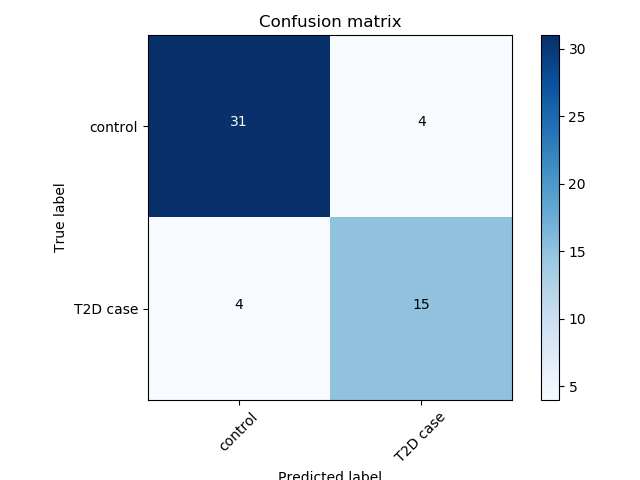

Confusion matrix, without normalization
[[31  4]
 [ 4 15]]


In [148]:
y_predicted = grid_search.best_estimator_.predict(X_test)
print('F1-score: ' + str(f1_score(y_test, y_predicted, average = 'micro')))
cnf_matrix = confusion_matrix(y_test, y_predicted)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['control','T2D case'],
                      title='Confusion matrix')

# 1.1 Using only the top 25 features

In [149]:
top_features = sorted(zip(feature_importances, risk_features), reverse=True)
top_features_25 = top_features[0:40]
top_features_25 = [x[1] for x in top_features_25]


In [150]:
X_train, X_test, y_train, y_test = train_test_split(dataset_risk_genes[top_features_25], dataset['labels'], test_size = 0.3)

param_grid = [
    {'n_estimators': [50, 75, 100], 'max_features':[None], 'criterion': ['gini'], 'max_leaf_nodes': [2, 20, 50, 75, 100, 125, 150], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 'max_leaf_nodes': [2, 20, 50, 75, 100, 125, 150], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class = ExtraTreesClassifier()
grid_search = GridSearchCV(extra_class, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_estimator_


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

F1-score: 0.8333333333333334


<IPython.core.display.Javascript object>


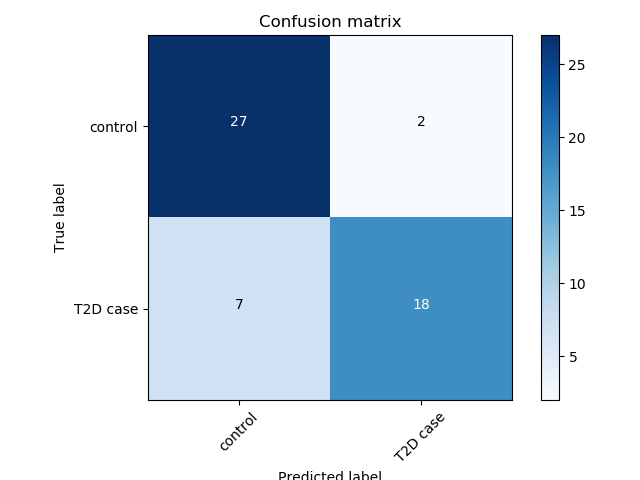

Confusion matrix, without normalization
[[27  2]
 [ 7 18]]


In [151]:
y_predicted = grid_search.best_estimator_.predict(X_test)
print('F1-score: ' + str(f1_score(y_test, y_predicted, average = 'micro')))
cnf_matrix = confusion_matrix(y_test, y_predicted)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['control','T2D case'],
                      title='Confusion matrix')

In [153]:
grid_search.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [4]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

# 1.2 Average for 100 runs with best parameters (only risk genes)

In [14]:
# Run several classifiers and find wich variants appear more

#Classifiers:
'''
CLASSIFIER 1
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

average accuracy: 0.74
average f1-score: 0.62

CLASSIFIER 2
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

average accuracy: 
average f1-score: 0.74

CLASSIFIER 3
ExtraTreesClassifier(n_estimators=50, n_jobs=-1)

average f1-score: 0.68


'''


f1_scores = []
accuracies = []
recalls = []
top_variants = np.array([])
dataset_list = list(dataset_risk_genes)
for run in range(0, 100):
    # Dividing train and test
    X_train, X_test, y_train, y_test = train_test_split(dataset_risk_genes, dataset['labels'], test_size = 0.3)

    print('Fitting model number: '  + str(run))

    # Random Forest Model
    rf_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
    rf_model.fit(X_train, y_train)

    # To save model
    #joblib.dump(rf_model, '../../data/rf_model.pkl') 

    print('Predicting...')

    # Predicting
    # y_predicted = rf_model.predict(X_test)
    y_predicted = cross_val_predict(rf_model, X_test, y_test, cv=5)
    # print(confusion_matrix(y_test, y_predicted))

    print('F1-score: ' + str(f1_score(y_test, y_predicted)) + '\nAccuracy: ' + \
         str(accuracy_score(y_pred = y_predicted, y_true = y_test)) + \
         '\nRecall: ' + str(recall_score(y_true=y_test, y_pred=y_predicted)))
    
    f1_scores.append(f1_score(y_test, y_predicted))
    accuracies.append(accuracy_score(y_pred = y_predicted, y_true = y_test))
    recalls.append(recall_score(y_true=y_test, y_pred=y_predicted))

# Results and important features
f1s = mean(f1_scores)
accuracy_mean = mean(accuracies)
recall_mean = mean(recalls)
print('Final f1 score: ' + str(f1s) + '\nFinal Accuraccy: ' + str(accuracy_mean))
frequencies = Counter(top_variants)


Fitting model number: 0
Predicting...
F1-score: 0.571428571429
Accuracy: 0.777777777778
Recall: 0.444444444444
Fitting model number: 1
Predicting...
F1-score: 0.48275862069
Accuracy: 0.722222222222
Recall: 0.388888888889
Fitting model number: 2
Predicting...
F1-score: 0.68085106383
Accuracy: 0.722222222222
Recall: 0.666666666667
Fitting model number: 3
Predicting...
F1-score: 0.5
Accuracy: 0.740740740741
Recall: 0.368421052632
Fitting model number: 4
Predicting...
F1-score: 0.577777777778
Accuracy: 0.648148148148
Recall: 0.52
Fitting model number: 5
Predicting...
F1-score: 0.615384615385
Accuracy: 0.722222222222
Recall: 0.521739130435
Fitting model number: 6
Predicting...
F1-score: 0.648648648649
Accuracy: 0.759259259259
Recall: 0.571428571429
Fitting model number: 7
Predicting...
F1-score: 0.625
Accuracy: 0.777777777778
Recall: 0.588235294118
Fitting model number: 8
Predicting...
F1-score: 0.68
Accuracy: 0.703703703704
Recall: 0.68
Fitting model number: 9
Predicting...
F1-score: 0.666

F1-score: 0.514285714286
Accuracy: 0.685185185185
Recall: 0.45
Fitting model number: 78
Predicting...
F1-score: 0.666666666667
Accuracy: 0.777777777778
Recall: 0.571428571429
Fitting model number: 79
Predicting...
F1-score: 0.666666666667
Accuracy: 0.777777777778
Recall: 0.571428571429
Fitting model number: 80
Predicting...
F1-score: 0.529411764706
Accuracy: 0.703703703704
Recall: 0.428571428571
Fitting model number: 81
Predicting...
F1-score: 0.744186046512
Accuracy: 0.796296296296
Recall: 0.761904761905
Fitting model number: 82
Predicting...
F1-score: 0.722222222222
Accuracy: 0.814814814815
Recall: 0.65
Fitting model number: 83
Predicting...
F1-score: 0.782608695652
Accuracy: 0.814814814815
Recall: 0.72
Fitting model number: 84
Predicting...
F1-score: 0.791666666667
Accuracy: 0.814814814815
Recall: 0.791666666667
Fitting model number: 85
Predicting...
F1-score: 0.739130434783
Accuracy: 0.777777777778
Recall: 0.68
Fitting model number: 86
Predicting...
F1-score: 0.893617021277
Accurac

# 2. Testing with the full dataset

In [6]:
pre_X = dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

param_grid = [
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['gini'],
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class_full = ExtraTreesClassifier()
grid_search_full = GridSearchCV(extra_class_full, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_full.fit(X_train, y_train)

grid_search_full.best_estimator_


KeyboardInterrupt: 

In [179]:
feature_importances = grid_search_full.best_estimator_.feature_importances_
sorted(zip(feature_importances, list(dataset)), reverse=True)

[(0.15863306529747578, 'EVPLL_LDA'),
 (0.1190207033855199, 'EVPLL_PCA'),
 (0.11077725896940843, 'FAM71E2_LDA'),
 (0.0655365774602478, 'FAM71E2_mean'),
 (0.06110208621203839, 'FAM71E2_PCA'),
 (0.041649637040476944, 'MAGEB3_variance'),
 (0.030874866507669855, 'TAB3_mean'),
 (0.028893464585997872, 'TAB3_LDA'),
 (0.027381810540270952, 'GPC4_PCA'),
 (0.024760325462171676, 'EVPLL_mean'),
 (0.022236787567358522, 'FAM120C_PCA'),
 (0.01818144080567339, 'GPC4_mean'),
 (0.01653289961173324, 'ECI1_mean'),
 (0.016211873811216897, 'NGLY1_LDA'),
 (0.01469771390058074, 'GPC4_LDA'),
 (0.0140044512444493, 'ECI1_PCA'),
 (0.013611192532162879, 'TAB3_PCA'),
 (0.013114469462480974, 'GABRA3_LDA'),
 (0.012659995547907199, 'SLC38A5_LDA'),
 (0.01175156933469532, 'WFS1_LDA'),
 (0.011055902429665304, 'ECI1_LDA'),
 (0.009959633798203162, 'FAM120C_mean'),
 (0.00965682491560716, 'FRMD7_LDA'),
 (0.009447803025579802, 'THADA_mean'),
 (0.008704332230462212, 'MAGEB3_LDA'),
 (0.008230863750131424, 'NGLY1_mean'),
 (0.0077

In [5]:
''' all data
CLASSIFIER 1
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
           
average f1-score: 0.79

All Data
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
average f1-score: 0.88 +- 0.006
average accuracy: 0.91 +- 0.004

only risk:
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
average f1-score: 0.77 +- 0.015
average accuracy: 0.83 +- 0.012

top features:
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
average f1-score: 0.89 +- 0.0032
average accuracy: 0.92 +- 0.0027

'''


def extra_trees(dataset, labels):
    
    dataset = dataset.drop('labels', axis = 1)
    f1_scores = []
    top_variants = np.array([])
    accuracies = []
    dataset_list = np.array(list(dataset))
    for run in range(0, 1):
        # Dividing train and test

        '''
        try:
            pre_X = dataset.drop('labels', axis = 1)
        except:
            pre_X = dataset
        
        X_train, X_test, y_train, y_test = train_test_split(pre_X, labels, test_size = 0.3)
        '''
        print('Fitting model number: '  + str(run))

        # Random Forest Model
        rf_model = tree.DecisionTreeClassifier()
        '''
        rf_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
        '''
        
        #rf_model.fit(X_train, y_train)

        # To save model
        #joblib.dump(rf_model, '../../data/rf_model.pkl') 

        print('Predicting...')

        # Predicting
        # y_predicted = rf_model.predict(X_test)
        
        y_predicted = cross_val_predict(rf_model, dataset, labels, cv=5)

        #y_predicted = cross_val_predict(rf_model, X_test, y_test, cv=5)
        # print(confusion_matrix(y_test, y_predicted))

        # Saving f1 score and all indexes
        #importances = rf_model.feature_importances_
        #importances_indexes = np.argsort(importances)[::-1]
        #importances_indexes = importances_indexes[0:100]

        print('F1-score: ' + str(f1_score(labels, y_predicted)) + '\nAccuracy: ' + \
         str(accuracy_score(y_pred = y_predicted, y_true = labels)))
              
        f1_scores.append(f1_score(labels, y_predicted))
        #top_variants = np.concatenate((top_variants, dataset_list[importances_indexes]))
        accuracies.append(accuracy_score(y_pred = y_predicted, y_true = labels))

              
    # Results and important features
    f1s = mean(f1_scores)
    accuracy_mean = mean(accuracies)
    print('Final f1 score: ' + str(f1s) + '\nFinal Accuraccy: ' + str(accuracy_mean))
    #frequencies = Counter(top_variants)
        
    return((f1s, f1_scores, accuracy_mean, accuracies, rf_model))
    

In [7]:
(f1s, f1_scores, accuracy_mean, accuracies, rf_model) = extra_trees(top50_dataset, dataset['labels'])

Fitting model number: 0
Predicting...
F1-score: 0.835820895522388
Accuracy: 0.8764044943820225
Final f1 score: 0.835820895522388
Final Accuraccy: 0.8764044943820225


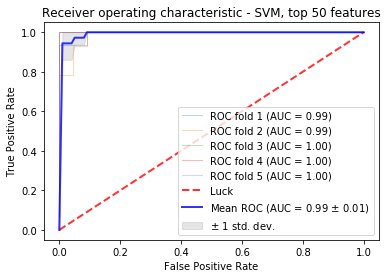

In [36]:
X = top50_dataset.drop('labels', axis = 1)
y = dataset['labels']

cv = StratifiedKFold(n_splits=5)

classifier = svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=True, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
'''
classifier = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
'''

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i+1, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic - SVM, top 50 features')
plt.legend(loc="lower right")
plt.savefig("../../data/plots/roc/svm_top", dpi = 300, bbox_inches='tight') 
plt.show()


In [ ]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [16]:
data = top50_dataset.drop('labels', axis = 1)
rf_model = rf_model.fit(data, dataset['labels'])
dot_data = tree.export_graphviz(rf_model, out_file=None, 
                         feature_names=list(data),  
                         class_names=['control', 'target'],  
                         filled=True, rounded=True,  
                         special_characters=True) 
graph = graphviz.Source(dot_data, format='png') 
graph
graph.render(filename='tree_rules')

'tree_rules.png'

In [59]:
f1_scores = np.array(f1_scores)
accuracies = np.array(accuracies)

print("F1-scores std:" + str(f1_scores.std()) + " Accuracies std: " + str(accuracies.std()))
#f1_scores.std()
#accuracies.std()

F1-scores std:0.0032495433754265385 Accuracies std: 0.0027728006020793475


## 2.1 Selecting top features for classifier

In [21]:
frequencies_plot_info = pd.DataFrame(columns = ['variant', 'frequency'])

count = 0
for key in frequencies.keys():
    frequencies_plot_info.loc[count] = [key, frequencies[key]]
    count += 1

frequencies_plot_info.head()

variant frequency
0     FAM71E2_PCA      1000
1    FAM71E2_mean      1000
2     FAM71E2_LDA      1000
3       EVPLL_LDA       995
4  EVPLL_variance       941

In [22]:
frequencies_plot_info['frequency'].astype(int, inplace = True)
frequencies_plot_info.sort_values(by = 'frequency', ascending = False, inplace = True)

frequencies_percentage = None
frequencies_percentage = frequencies_plot_info
frequencies_percentage['frequency'] = (frequencies_plot_info['frequency'] / 1000) * 100

In [23]:
frequencies_percentage.to_csv("../../data/knownvariants/top_genes_classification.csv")

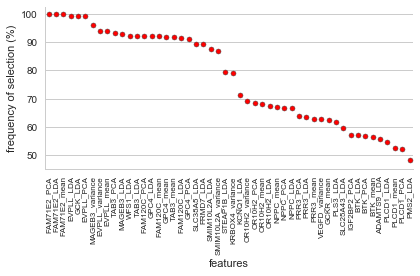

In [24]:
plt.figure()
sns.set()
sns.set_style('whitegrid')
#sns.set_style()

plot = sns.stripplot(x = "variant", y = "frequency", data = frequencies_percentage[0:50], color = "red", linewidth=.5)

sns.despine()
plot.set_xticklabels(plot.get_xticklabels(), rotation=90, fontsize = 8)
#plt.xlim(0, 60)
plt.ylabel('frequency of selection (%)')
plt.xlabel('features')
plt.tight_layout()
plt.savefig("../../data/plots/top_features_all_vs_all/top50_features.png", dpi = 300, bbox_inches='tight') 
plt.show()

In [19]:
#top_features = frequencies_plot_info.iloc[0:50, 0]
#top_features = list(top_features)
#top_features.append('labels')
#top_features

# New dataset
#top50_dataset = dataset[list(top_features)]
#top50_dataset.to_csv('../../data/full_dataset/full_data_new_features_top_50.csv')
top50_dataset = pd.read_csv('../../data/full_dataset/full_data_new_features_top_50.csv')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

top50_dataset = top50_dataset.drop(top50_dataset.columns[0], axis = 1)
top50_dataset


FAM71E2_PCA  FAM71E2_LDA  FAM71E2_mean  EVPLL_LDA   GCK_LDA  EVPLL_PCA  \
0      -0.871782    -0.978452           0.0   0.859112 -0.608028  -0.407446   
1      -0.871782    -0.978452           0.0   0.859112 -0.119657  -0.407446   
2       1.954985     1.855746           2.0   0.859112  0.007076  -0.407446   
3       0.590042     2.673006           1.0   0.859112  1.562383  -0.407446   
4       0.541601     0.438647           1.0   0.859112  1.140437  -0.407446   
5       0.541601     0.438647           1.0   0.859112  0.019642  -0.407446   
6      -0.140870     0.847277           0.5   0.859112  0.179722  -0.407446   
7       0.541601     0.438647           1.0   0.859112 -0.306913  -0.407446   
8       0.541601     0.438647           1.0   0.630787  0.636414  -0.052383   
9       1.954985     1.855746           2.0   0.859112 -1.362806  -0.407446   
10      0.590042     2.673006           1.0   0.859112  0.764246  -0.407446   
11      0.541601     0.438647           1.0   0.859112  0.764253  -0.407446   
12      0.541601     0.438647           1.0   0.859112  2.652531  -0.407446   
13      0.541601     0.438647           1.0   0.859112  1.792290  -0.407446   
14     -0.871782    -0.978452           0.0   0.158443  2.639382  -0.256729   
15      0.541601     0.438647           1.0   0.859112  1.488820  -0.407446   
16      0.541601     0.438647           1.0   0.859112  1.190637  -0.407446   
17      0.541601     0.438647           1.0   0.859112  2.879859  -0.407446   
18      0.541601     0.438647           1.0   0.859112 -0.313549  -0.407446   
19      0.541601     0.438647           1.0   0.859112  2.652531  -0.407446   
20      0.590042     2.673006           1.0   0.859112  2.407582  -0.407446   
21      1.954985     1.855746           2.0   0.859112  0.974672  -0.407446   
22      0.541601     0.438647           1.0   0.859112  0.412816  -0.407446   
23      1.954985     1.855746           2.0   0.859112  1.721060  -0.407446   
24      0.590042     2.673006           1.0   0.859112 -0.614222  -0.407446   
25     -0.871782    -0.978452           0.0   0.859112  0.734195  -0.407446   
26      0.541601     0.438647           1.0  -0.542225  2.652531  -0.106011   
27      1.954985     1.855746           2.0   0.859112  0.007076  -0.407446   
28      0.541601     0.438647           1.0   0.859112 -0.306913  -0.407446   
29      1.954985     1.855746           2.0   0.859112 -1.034031  -0.407446   
30      0.541601     0.438647           1.0   0.859112  0.734195  -0.407446   
31      0.541601     0.438647           1.0   0.859112  0.179722  -0.407446   
32      1.954985     1.855746           2.0   0.859112  0.138668  -0.407446   
33      1.954985     1.855746           2.0   0.859112  0.734195  -0.407446   
34      0.541601     0.438647           1.0   0.859112  1.117332  -0.407446   
35      0.541601     0.438647           1.0   0.859112 -1.033626  -0.407446   
36      0.541601     0.438647           1.0   0.859112  0.412816  -0.407446   
37      0.541601     0.438647           1.0   0.859112  0.429219  -0.407446   
38      0.541601     0.438647           1.0   0.859112 -1.016166  -0.407446   
39      0.590042     2.673006           1.0  -3.127405  2.652531   1.437780   
40      1.954985     1.855746           2.0   0.859112 -0.262792  -0.407446   
41      0.541601     0.438647           1.0   0.859112  2.652531  -0.407446   
42      0.541601     0.438647           1.0   0.859112  0.915218  -0.407446   
43     -0.871782    -0.978452           0.0   0.859112  2.652531  -0.407446   
44      0.541601     0.438647           1.0   0.859112 -1.950252  -0.407446   
45     -0.871782    -0.978452           0.0   0.402462  2.260490   0.302679   
46     -0.871782    -0.978452           0.0   0.859112  0.198957  -0.407446   
47     -0.871782    -0.978452           0.0   0.859112  3.044572  -0.407446   
48      0.541601     0.438647           1.0   0.859112  1.488820  -0.407446   
49      0.541601     0.438647           1.0   0.859112 

In [21]:
pd.set_option('display.max_rows', 500)
frequencies_plot_info[0:50]
#list(top50_dataset)

variant frequency
0           FAM71E2_LDA      1000
2          FAM71E2_mean      1000
1           FAM71E2_PCA      1000
3             EVPLL_LDA       998
9             EVPLL_PCA       996
5               GCK_LDA       985
8       MAGEB3_variance       957
34       EVPLL_variance       937
20           EVPLL_mean       931
19          FAM120C_LDA       920
7            MAGEB3_LDA       918
10             TAB3_LDA       916
11             GPC4_LDA       913
13             WFS1_LDA       910
23         FAM120C_mean       908
31             GPC4_PCA       908
18          FAM120C_PCA       908
15            GPC4_mean       908
22            TAB3_mean       906
14             TAB3_PCA       897
29          SLC38A5_LDA       866
12            FRMD7_LDA       860
4    SMIM10L2A_variance       854
6         SMIM10L2A_LDA       853
59      KRBOX4_variance       772
49          STEAP1B_LDA       761
51            KCNQ1_LDA       717
17             NPPC_PCA       659
196         OR10H2_mean       658
67           OR10H2_LDA       656
37             NPPC_LDA       656
30            NPPC_mean       653
70           OR10H2_PCA       651
199     OR10H2_variance       644
129      VEGFD_variance       630
40             PRR3_PCA       618
54            PRR3_mean       614
39             PRR3_LDA       608
87         SLC25A43_LDA       593
63            GCKR_mean       593
176            PLS3_LDA       590
100             BTK_PCA       589
101            BTK_mean       587
92              BTK_LDA       563
95           PLCD1_mean       551
190           PLCD1_PCA       550
214           PLCD1_LDA       545
80          IGF2BP2_PCA       534
57          ADAMTS9_LDA       526
169            PMS2_LDA       496

## 2.2 Classify with top 50 features

In [60]:
pre_X = top50_dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, top50_dataset['labels'], test_size = 0.3)

param_grid = [
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['gini'],
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class_full = ExtraTreesClassifier()
grid_search_full = GridSearchCV(extra_class_full, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_full.fit(X_train, y_train)

grid_search_full.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [38]:
'''
CLASSIFIER 1
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
           
average f1-score: 0.84

CLASSIFIER 2
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
           
average f1-score: 0.87

'''

(f1s, f1_scores, accuracy_mean, accuracies, frequencies) = extra_trees(top50_dataset, dataset['labels'])

Fitting model number: 0
Predicting...
F1-score: 0.8636363636363636
Accuracy: 0.8888888888888888
Fitting model number: 1
Predicting...
F1-score: 0.9
Accuracy: 0.9259259259259259
Fitting model number: 2
Predicting...
F1-score: 0.909090909090909
Accuracy: 0.9259259259259259
Fitting model number: 3
Predicting...
F1-score: 0.9259259259259259
Accuracy: 0.9259259259259259
Fitting model number: 4
Predicting...
F1-score: 0.9
Accuracy: 0.9259259259259259
Fitting model number: 5
Predicting...
F1-score: 0.9387755102040817
Accuracy: 0.9444444444444444
Fitting model number: 6
Predicting...
F1-score: 0.9047619047619047
Accuracy: 0.9259259259259259
Fitting model number: 7
Predicting...
F1-score: 0.8571428571428572
Accuracy: 0.8703703703703703
Fitting model number: 8
Predicting...
F1-score: 0.8421052631578947
Accuracy: 0.8888888888888888
Fitting model number: 9
Predicting...
F1-score: 0.7567567567567567
Accuracy: 0.8333333333333334
Fitting model number: 10
Predicting...
F1-score: 0.851063829787234
Accu

F1-score: 0.9473684210526315
Accuracy: 0.9629629629629629
Fitting model number: 87
Predicting...
F1-score: 0.761904761904762
Accuracy: 0.8148148148148148
Fitting model number: 88
Predicting...
F1-score: 0.8085106382978724
Accuracy: 0.8333333333333334
Fitting model number: 89
Predicting...
F1-score: 0.851063829787234
Accuracy: 0.8703703703703703
Fitting model number: 90
Predicting...
F1-score: 0.9615384615384615
Accuracy: 0.9629629629629629
Fitting model number: 91
Predicting...
F1-score: 0.9090909090909091
Accuracy: 0.9259259259259259
Fitting model number: 92
Predicting...
F1-score: 0.8333333333333333
Accuracy: 0.8888888888888888
Fitting model number: 93
Predicting...
F1-score: 0.9130434782608695
Accuracy: 0.9259259259259259
Fitting model number: 94
Predicting...
F1-score: 0.888888888888889
Accuracy: 0.8888888888888888
Fitting model number: 95
Predicting...
F1-score: 0.9130434782608695
Accuracy: 0.9259259259259259
Fitting model number: 96
Predicting...
F1-score: 0.9019607843137256
Accu

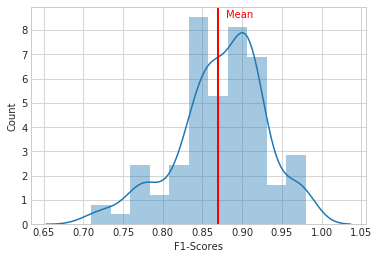

In [31]:
plt.figure()
sns.distplot(f1_scores)
plt.xlabel('F1-Scores')
plt.ylabel('Count')
plt.plot([0.87, 0.87], [0, 12], 'r-', lw=2)
plt.text(s = 'Mean', y = 8.5, x = 0.88, color = 'red')
plt.savefig("../../data/plots/f1s_top_50_rf/2.png") 
plt.show()

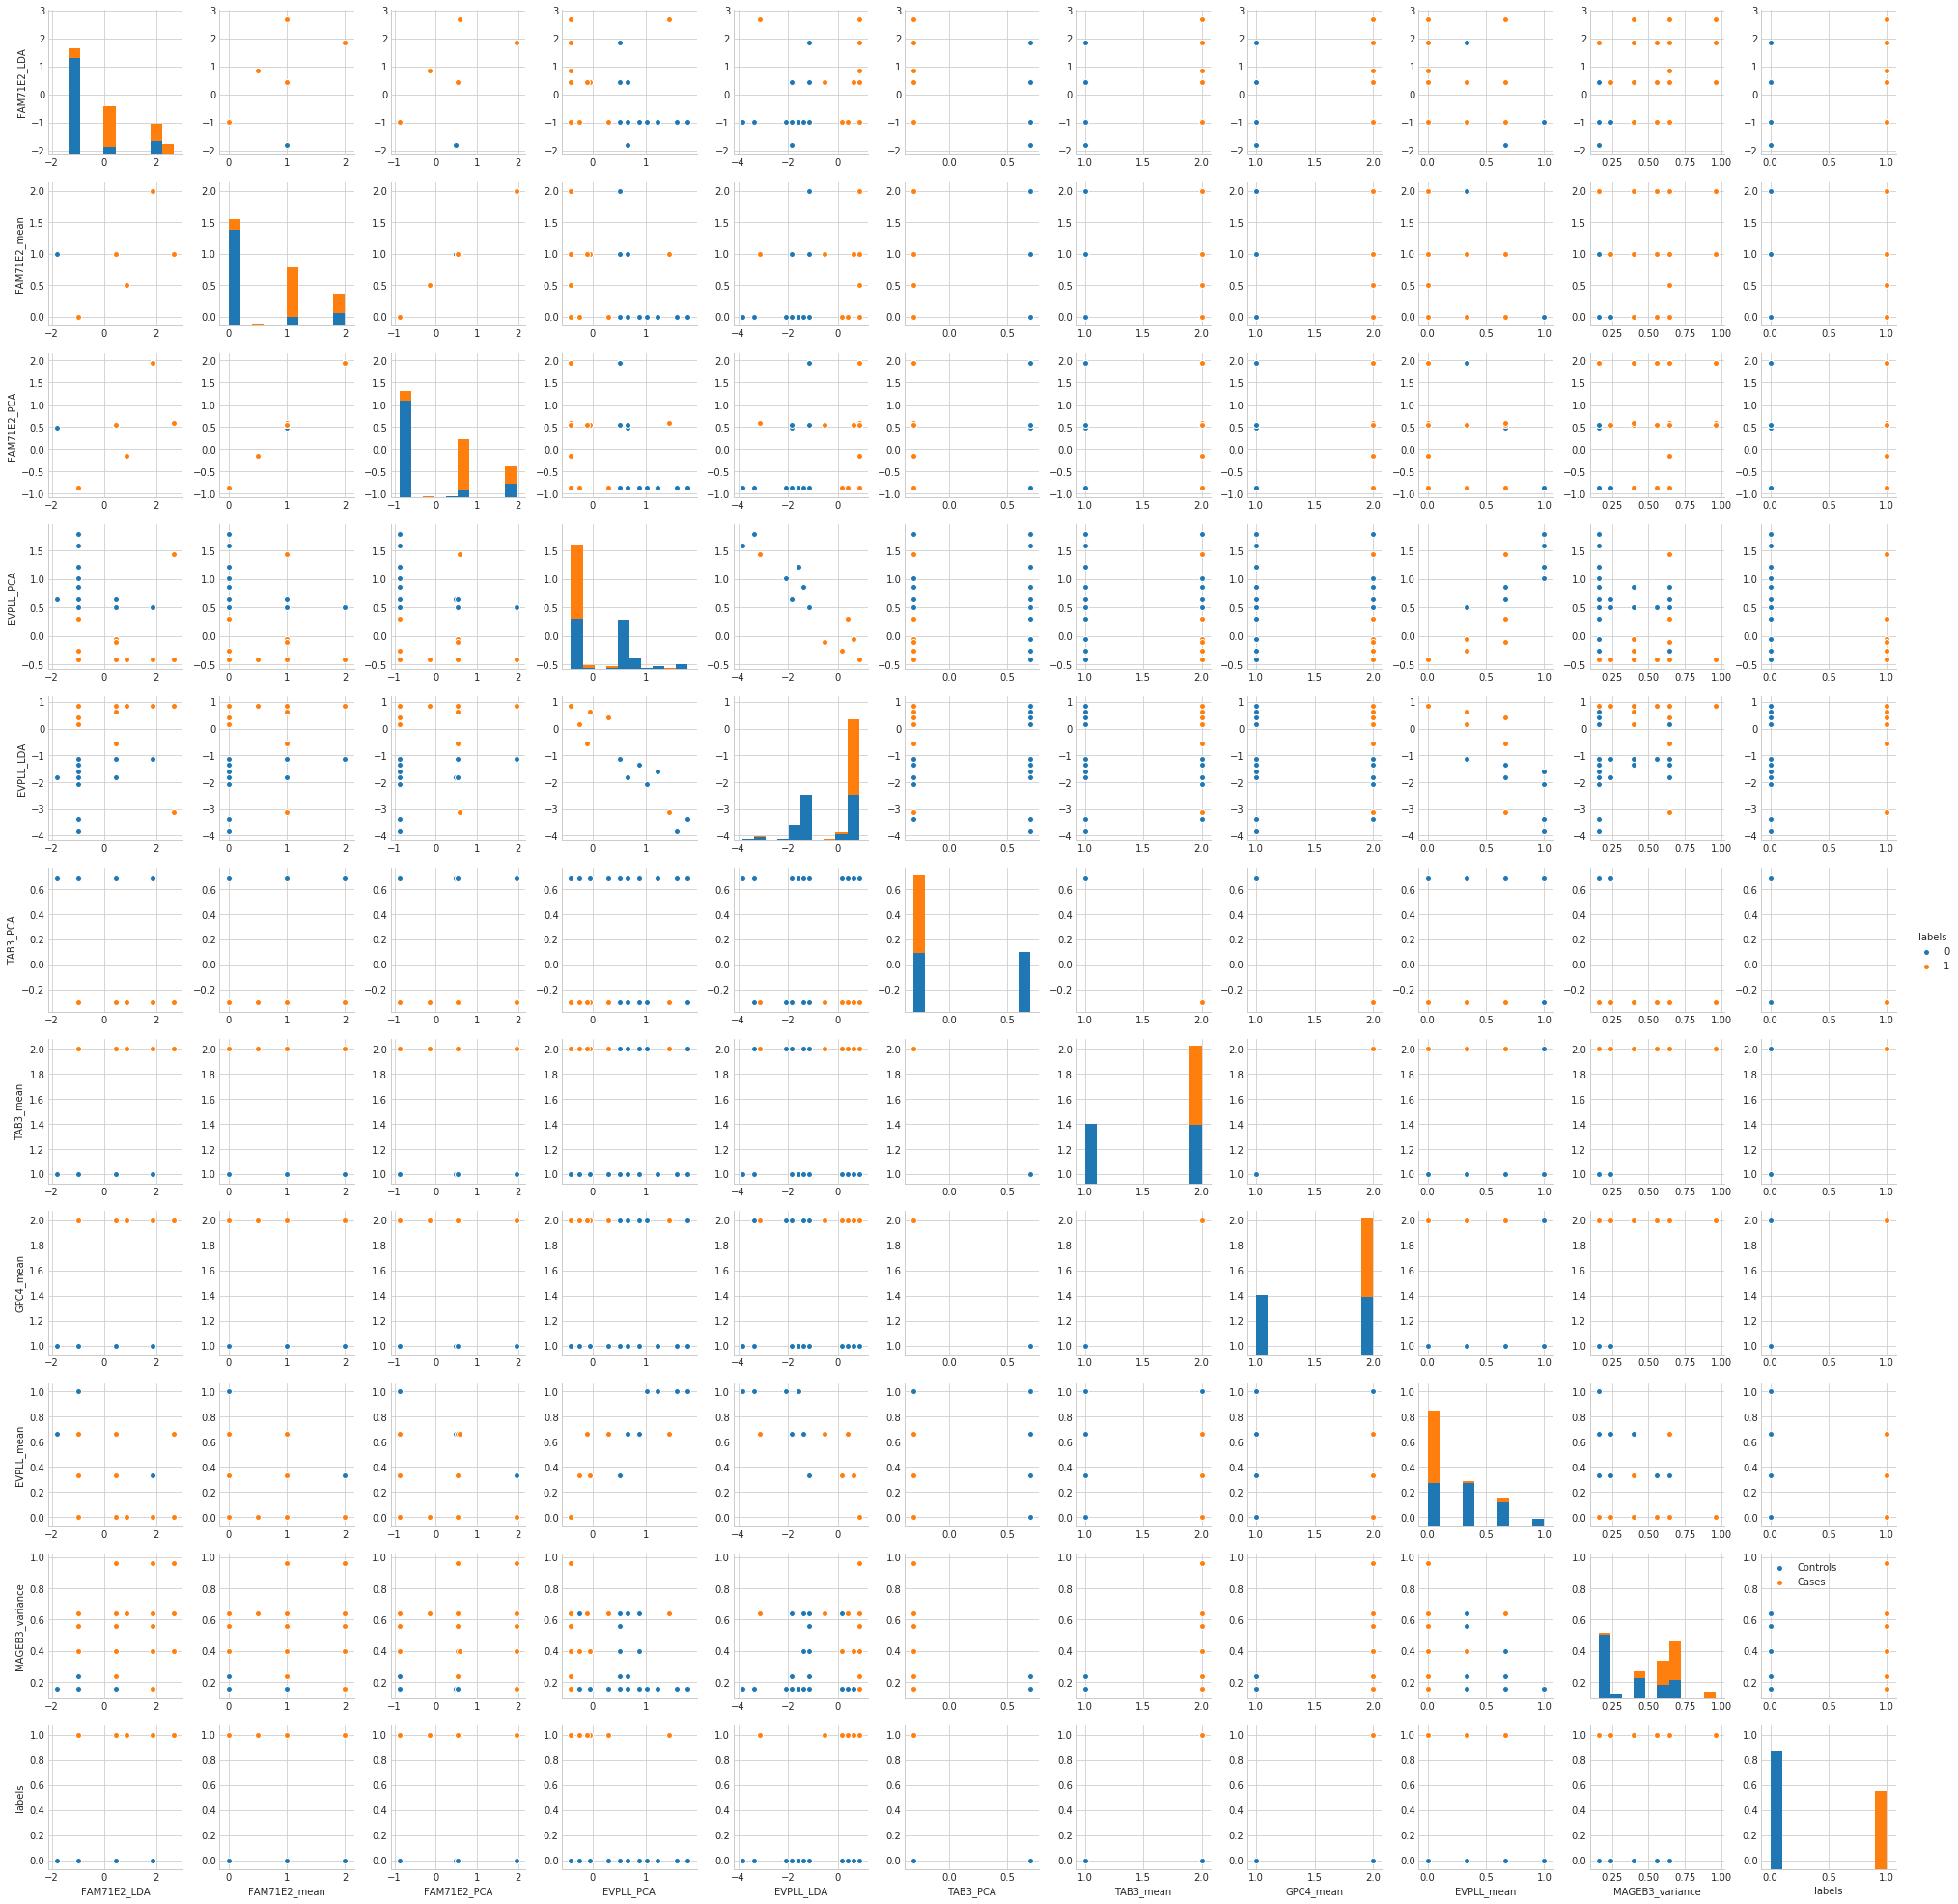

In [32]:
# top 10 features vs each other
test = top50_dataset[['FAM71E2_LDA', 'FAM71E2_mean', 'FAM71E2_PCA', 'EVPLL_PCA', 'EVPLL_LDA', 'TAB3_PCA', 'TAB3_mean', 'GPC4_mean', 'EVPLL_mean', 'MAGEB3_variance', 'labels']]

sns.pairplot(data = test, hue = 'labels')
plt.legend(['Controls', 'Cases'], loc = 0)
plt.savefig("../../data/plots/top_features_all_vs_all/1.png")

# 3. Testing an SVM classifier (with top 50 features)

In [12]:
pre_X = top50_dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

param_grid = [
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C':[0.25, 0.4, 0.5, 0.55, 0.75, 1],
     'tol':[1e-3, 1e-4, 1e-5], 'gamma':[25, 50, 75, 100, 150, 'auto'], 'degree':[1,2,3,5,10]}
]

svm_class_full = svm.SVC()
grid_search_full_svm = GridSearchCV(svm_class_full, param_grid, cv=5, scoring='neg_mean_squared_error', verbose = 51)
grid_search_full_svm.fit(X_train, y_train)

grid_search_full_svm.best_estimator_

Fitting 5 folds for each of 3600 candidates, totalling 18000 fits
[CV] C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.120000, total=   0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.083333, total=   0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  

[CV]  C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=1, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=1, gamma=25, kernel=rb

[CV] C=0.25, degree=1, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=linear, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=1, gamma=50, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=1, gamma=50, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=1, gamma=50, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=

[CV]  C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=1, gamma=50, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=1, gamma

[CV]  C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=75, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=1, gamma=75, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=1, gamma=75, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=1, gamma=75, kernel=rb

[CV]  C=0.25, degree=1, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=linear, tol=0.01 ............
[CV]  C=0.25, degree=1, gamma=10

[CV]  C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=1, gamma=100, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=1, gamma=100, k

[CV]  C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=poly, tol=0.1 ...............
[CV]  C=0.25, degree=1, gamma=150, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=poly, tol=0.1 ...............
[CV]  C=0.25, degree=1, ga

[CV]  C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.01 ...........
[CV]  C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.01, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=1, gamma=150, kernel=sigmoid, tol=0.01 ...........
[CV]  C=0.25, degree=1, gam

[CV]  C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.0001 ...........
[CV]  C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=poly, tol=0.0001 ...........
[CV]  C=0.25, degree=1, gam

[CV]  C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=

[CV]  C=0.25, degree=2, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.25, degree=2, gamma=25, kernel=rbf, tol=0.01,

[CV]  C=0.25, degree=2, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=linear, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=2, gamma=50, ker

[CV]  C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=2, gamma=50, kernel=r

[CV]  C=0.25, degree=2, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=2, gamma=75, kernel=linear, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=2, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.25, degree=2, gamma=75, kernel

[CV] C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.1, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.01, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=2, gamma=75, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=2, gamma=75

[CV]  C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=2, gamma=100, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=100, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=

[CV]  C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=2, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=2, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=2, gamma=150, kernel=linear, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=2

[CV] C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=2, gamma=150, kernel=rb

[CV]  C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, d

[CV]  C=0.25, degree=2, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.25, degree=2, gamma=aut

[CV]  C=0.25, degree=3, gamma=25, kernel=poly, tol=0.1, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01 ...............
[CV]  C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01 ...............
[CV]  C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01 ...............
[CV]  C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01 ...............
[CV]  C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01 ...............
[CV]  C=0.25, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.25, degree=3, gamma=25, kernel=poly, 

[CV]  C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.01, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=3, 

[CV]  C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05 ..............
[CV]  C=0.25, degree=3, gamma=50, kernel=poly, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=3, gamma=50, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=rbf, tol=0.1 .................
[CV]  C=0.25, degree=3, gamma=50, kernel=rb

[CV]  C=0.25, degree=3, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=3, gamma=50, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.25, degree=3, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=linear, tol=0.1 ..............
[CV]  C=0.25, degree=3, gamma=75, 

[CV]  C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=3, gamma=75, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=3, gamma=75, kernel=rbf,

[CV]  C=0.25, degree=3, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05 ...........
[CV]  C=0.25, degree=3, gamma=100, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=poly, tol=0.1 ...............
[CV]  C=0.25, degree=

[CV]  C=0.25, degree=3, gamma=100, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=3, gamma=100, kernel=sigmoid, tol=0.01 ...........
[CV]  C=0.25, degree=3, gamma=

[CV] C=0.25, degree=3, gamma=150, kernel=poly, tol=0.001 .............
[CV]  C=0.25, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=3, gamma=

[CV]  C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=0.0001, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=0.0001, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=3, gamma=150, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.25, 

[CV]  C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01 ..............
[CV]  C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01 ..............
[CV]  C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01 ..............
[CV]  C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01 ..............
[CV]  C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01 ..............
[CV]  C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=3, gamma=auto, kernel=rbf, tol=0.001 .............
[CV]  C=0.25, degree=3, gamma=auto, kerne

[CV] C=0.25, degree=5, gamma=25, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=linear, tol=0.01 .............
[CV]  C=0.25, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=linear, tol=0.001 ............
[CV]  C=0.25, degree=5, gamma=25, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=linear, tol=0.001 ............
[CV]  C=0.25, degree=5, gamma=25, kernel=linear, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=linear, tol=0.001 ............
[CV]  C=0.25, degree=5, gamma=25, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25

[CV]  C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.25, degree=5, gamma=25, kernel=rb

[CV]  C=0.25, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.25, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.25, degree=5, ga

[CV]  C=0.25, degree=5, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.25, degree=5, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.25, degree=5, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=5, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.25, degree=5, gamma=50, kernel

[CV]  C=0.25, degree=5, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001, score=-0.166667, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.25, degree=5, gamma=75, kernel=

[CV]  C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.001, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=5, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.25, degre

[CV]  C=0.25, degree=5, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.25, degree=5, gamma=100, kernel=rbf, to

[CV] C=0.25, degree=5, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=5, gamma=150, kernel=linear, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=5, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.25, degree=5, gamma=150, kernel=linear, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=5, gamma=1

[CV]  C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.25, degree=5, gamma=150, ke

[CV]  C=0.25, degree=5, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=linear, tol=1e-05 ..........
[CV]  C=0.25, degree=5, gamma=auto, kernel=linear, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=linear, tol=1e-05 ..........
[CV]  C=0.25, degree=5, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1, score=-0.280000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.25, degree=5, gamm

[CV]  C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=5, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.25, degree

[CV]  C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001, score=-0.076923, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001 .............
[CV]  C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001 .............
[CV]  C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001 .............
[CV]  C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001, score=-0.250000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001 .............
[CV]  C=0.25, degree=10, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=10, gamma=25, kernel=poly, tol=0.0001, score=-0.076923, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=poly, tol=0.0001 ............
[CV]  C=0.25, degree=10, gamma=25

[CV]  C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=10, gamma=25, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.25, 

[CV]  C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05, score=-0.250000, total=   0.0s
[CV] C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=50, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=50, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=10, gamma=50, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=10, gamma=50, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=10, gamma=50, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=50, kernel=rbf, tol=0.1 ................
[CV]  C=0.25, degree=10, gamma=50, kerne

[CV]  C=0.25, degree=10, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1 .............
[CV]  C=0.25, degree=10, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=linear, tol=0.01 ............
[CV]  C=0.25, degree=10, gamma=

[CV]  C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=75, kernel=rbf, tol=0.001 ..............
[CV]  C=0.25, degree=10, gamma=75, kernel=r

[CV] C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.25, degree=10, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=linear, tol=1e-05 ..........
[CV]  C=0.25, degree=10, gamma=100, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25

[CV]  C=0.25, degree=10, gamma=100, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.25, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=100, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.25, degree=10, gamma=10

[CV]  C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01 .............
[CV]  C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01 .............
[CV]  C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.250000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01 .............
[CV]  C=0.25, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=10, gamma=150, kernel=poly, tol=0.001, score=-0.153846, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=10, gamma=150, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=poly, tol=0.001 ............
[CV]  C=0.25, degree=10, gamma=1

[CV]  C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001, score=-0.346154, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001, score=-0.500000, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.25, degree=10, gamma=150, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.2

[CV]  C=0.25, degree=10, gamma=auto, kernel=poly, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.25, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=rbf, tol=0.1 ..............
[CV]  C=0.25, degree=

[CV]  C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.25, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=linear, tol=0.1 ...............
[CV]  C=0.4, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=linear, tol=0.1 ...............
[CV]  C=0.4

[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=1, gamma=25, kernel=rbf, tol=0.00

[CV]  C=0.4, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=linear, tol=0.0001 ............
[CV]  C=0.4, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=linear, tol=0.0001 ............
[CV]  C=0.4, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05 .............
[CV]  C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05 .............
[CV]  C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05 .............
[CV]  C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=linear, tol=1e-05 .............
[CV]  C=0.4, degree=1, gamma=50

[CV]  C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.01, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=1, gamma=50, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.4, degree=1, gamma=50, kernel

[CV]  C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001 ..............
[CV]  C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001 ..............
[CV]  C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001 ..............
[CV]  C=0.4, degree=1, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=poly, tol=1e-05 ...............
[CV]  C=0.4, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=poly, tol=1e-05 ...............
[CV]  C=0.4, degree=1, gamma=75, kernel=poly, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=poly, tol=1e-05 ...............
[CV]  C=0.4, degree=1, gamma=75, kernel=po

[CV]  C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=100, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=1, gamma=100

[CV]  C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001 ...............
[CV]  C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001 ...............
[CV]  C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001 ...............
[CV]  C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=1, gamma=100, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=1, gamma=100, kernel=rbf

[CV]  C=0.4, degree=1, gamma=150, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=linear, tol=0.0001 ...........
[CV]  C=0.4, degree=1, gamma=150, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=1, gam

[CV]  C=0.4, degree=1, gamma=150, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=1, gamma=150, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=1, gamma=150, ke

[CV]  C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.001 .............
[CV]  C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.001 .............
[CV]  C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001 ............
[CV]  C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001 ............
[CV]  C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001 ............
[CV]  C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=poly, tol=0.0001 ............
[CV]  C=0.4, degree=1, gamma=au

[CV]  C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.4

[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01 .................
[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01 .................
[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01 .................
[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01 .................
[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01 .................
[CV]  C=0.4, degree=2, gamma=25, kernel=rbf, tol=0.01, score

[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=50, kernel=rbf, tol=1e-05 ................
[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=2, gamma=50, kernel=rbf, tol=1e-05 ................
[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=50, kernel=rbf, tol=1e-05 ................
[CV]  C=0.4, degree=2, gamma=50, kernel=rbf, tol

[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=poly, tol=0.1 .................
[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=poly, tol=0.1 .................
[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=2, gamma=75, kernel=poly, tol=0.01,

[CV]  C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=7

[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.01 ................
[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.01 ................
[CV]  C=0.4, degree=2, gamma=100, kernel=rbf, tol=0.01, s

[CV]  C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01 .............
[CV]  C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01 .............
[CV]  C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01 .............
[CV]  C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01 .............
[CV]  C=0.4, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=linear, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=linear, tol=0.001 ............
[CV]  C=0.4, degree=2, gamma=150,

[CV] C=0.4, degree=2, gamma=150, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=2, gamma=150, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=2, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=2, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=2, gamma=150, kernel=rbf

[CV]  C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01 ..............
[CV]  C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01 ..............
[CV]  C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01 ..............
[CV]  C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01 ..............
[CV]  C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01 ..............
[CV]  C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=poly, tol=0.001 .............
[CV]  C=0.4, degree=2, gamma=auto, kernel

[CV]  C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.4, de

[CV]  C=0.4, degree=3, gamma=25, kernel=poly, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.01 .................
[CV]  C=0.4, degree=3, gamma=25, kernel=rbf, tol=0.01, score=

[CV] C=0.4, degree=3, gamma=50, kernel=linear, tol=0.1 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=linear, tol=0.1 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=3, gamma=50, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=lin

[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=50, kernel=rbf, tol=1e-05 ................
[CV]  C=0.4, degree=3, gamma=50, kernel=rbf, to

[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.1, score=-0.041667, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=3, gamma=75, kernel=poly, tol=0.01, s

[CV]  C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=3, gamma=75,

[CV]  C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.4, degree=3, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=100, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=3, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.4, degree=3, gamma=100, kernel=rbf, 

[CV]  C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=linear, tol=0.01 .............
[CV]  C=0.4, degree=3, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=linear, tol=0.01 .............
[CV]  C=0.4, degree=3, gamma=150, kerne

[CV]  C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001 ...............
[CV]  C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001 ...............
[CV]  C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001 ...............
[CV]  C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=3, gamma=150, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=3, gamma=150, kernel=rbf

[CV]  C=0.4, degree=3, gamma=auto, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=linear, tol=0.0001 ..........
[CV]  C=0.4, degree=3, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05 ...........
[CV]  C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05 ...........
[CV]  C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05 ...........
[CV]  C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05 ...........
[CV]  C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=linear, tol=1e-05 ...........
[CV]  C=0.4, degree=

[CV]  C=0.4, degree=3, gamma=auto, kernel=rbf, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.4, degree=3, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=3, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.4, degree=3, gamma=aut

[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol=0.01, score=-0.166667, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.4, degree=5, gamma=25, kernel=poly, tol

[CV] C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.4, degree=5, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=5, gamma

[CV]  C=0.4, degree=5, gamma=50, kernel=poly, tol=1e-05, score=-0.166667, total=   0.0s
[CV] C=0.4, degree=5, gamma=50, kernel=poly, tol=1e-05 ...............
[CV]  C=0.4, degree=5, gamma=50, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.4, degree=5, gamma=50, kernel=rbf, tol=0.1, scor

[CV]  C=0.4, degree=5, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=linear, tol=0.1 ...............
[CV]  C=0.4, degree=5, gamma=75, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=linear, tol=0.1 ...............
[CV]  C=0.4, degree=5, gamma=75, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.4, degree=5, gamma=75, kernel=lin

[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.001 ................
[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=5, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.4, degree=5, gamma=75, kernel=rbf, tol=

[CV]  C=0.4, degree=5, gamma=100, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=5, gamma=100, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1 ................
[CV]  C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1 ................
[CV]  C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1 ................
[CV]  C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1 ................
[CV]  C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1, score=-0.166667, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=poly, tol=0.1 ................
[CV]  C=0.4, degree=5, gamma=100, kernel=pol

[CV]  C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=5, gamma=100, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=5, gamma=10

[CV]  C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001 .............
[CV]  C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001 .............
[CV]  C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001, score=-0.166667, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001 .............
[CV]  C=0.4, degree=5, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=5, gamma=150, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=5, gamma=150, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=5, gamma=150, ke

[CV]  C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.4, degree=5, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=linear, tol=0.1 .............
[CV]  C=0.4, degree=5, gamma=auto, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=linear, tol=0.1 .............
[CV]  C=0.4, degree=5, g

[CV]  C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01 ...............
[CV]  C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01 ...............
[CV]  C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01 ...............
[CV]  C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=5, gamma=auto, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=5, gamma=auto, kernel=rb

[CV]  C=0.4, degree=10, gamma=25, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001 ...........
[CV]  C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001 ...........
[CV]  C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001 ...........
[CV]  C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001 ...........
[CV]  C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001 ...........
[CV]  C=0.4, degree=10, gamma=25, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=linear, tol=1e-05 ............
[CV]  C=0.4, degree=10,

[CV]  C=0.4, degree=10, gamma=25, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.4, degree=10, gamma=25, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=25, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.4, degree=10, gamma=25, kernel=rbf

[CV] C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.076923, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.250000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=poly, tol=0.001 ..............
[CV]  C=0.4, degree=10, gamma=50, kernel=poly, tol=0.001, score=-0.076923, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=poly,

[CV]  C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.4, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.4, degree=10, g

[CV] C=0.4, degree=10, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.4, degree=10, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.076923, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.250000, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel

[CV] C=0.4, degree=10, gamma=75, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.4, degree=10, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.4, degree=10, gamma=75, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.4, degree=10, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1 .............
[CV]  C=0.4, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=10, gamma=1

[CV]  C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=100, kernel=rbf, tol=0.001 ..............
[CV]  C=0.4, degree=10, gamma=100, kernel=r

[CV]  C=0.4, degree=10, gamma=150, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.4, degree=10, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001 ..........
[CV]  C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001 ..........
[CV]  C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001 ..........
[CV]  C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001 ..........
[CV]  C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=linear, tol=0.0001 ..........
[CV]  C=0.4, degre

[CV]  C=0.4, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.4, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.4, degree=10, gamma=150, ker

[CV]  C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01, score=-0.360000, total=   0.0s
[CV] C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.4, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.4, degree=10, gamma=auto, 

[CV]  C=0.5, degree=1, gamma=25, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.5, degree=1, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=1, gamma=25, kernel=po

[CV] C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.5, degree=1, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=1, ga

[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.001 ................
[CV]  C=0.5, degree=1, gamma=50, kernel=rbf, tol=0.001, sco

[CV] C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=1, gamma=75, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=1, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=1, gamma=75, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel

[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=1, gamma=75, kernel=rbf, tol=

[CV]  C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=1, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=1, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=1, gamma=100, kernel=poly

[CV]  C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=1, gamma=100, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree

[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.1 .................
[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=1, gamma=150, kernel=rbf, tol=0.01

[CV]  C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.0001 ..........
[CV]  C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=linear, tol=0.0001 ..........
[CV]  C=0.5, degree=1

[CV]  C=0.5, degree=1, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=1, gamma=auto, kernel=rbf, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=1, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=1, gamma=auto, kernel=sigmoid, tol=0.1 ............
[CV]  C=0.5, degree=1, gamma=auto,

[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.5, degree=2, gamma=25, kernel=poly, tol=

[CV]  C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=2, gamma=25, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=2, gamma=

[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1 ..................
[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-

[CV] C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=2, gamma=75, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=2, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=2, gamma=75, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel

[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=75, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=2, gamma=75, kernel=rbf, tol

[CV]  C=0.5, degree=2, gamma=100, kernel=poly, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=poly, tol=0.1 ................
[CV]  C=0.5, degree=2, gamma=100, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=2, gamma=100, kernel=poly, t

[CV]  C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=2, gamma=100, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=2

[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1 .................
[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1 .................
[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1 .................
[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=2, gamma=150, kernel=rbf, tol=0.01, 

[CV]  C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01 ............
[CV]  C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01 ............
[CV]  C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01 ............
[CV]  C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=2, gam

[CV] C=0.5, degree=2, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=2, gamma=auto, kernel=rbf, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=2, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=2, gamma=auto, kern

[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=poly, tol=0.001 ...............
[CV]  C=0.5, degree=3, gamma=25, kernel=poly, tol=0

[CV] C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.01, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001 ............
[CV]  C=0.5, degree=3, gamma=25, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=3, gamma=25

[CV]  C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=3, gamma=50, kernel=poly, tol=0.0001, score=-0.041667, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=poly, tol=1e-05 ...............
[CV]  C=0.5, degree=3, gamma=50, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=poly, tol=1e-05 ...............
[CV]  C=0.5, degree=3, gamma=50, kernel=p

[CV]  C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=50, kernel=sigmoid, tol=1e-05 ............
[CV]  C=0.5, degree=3, ga

[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01 .................
[CV]  C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.001 ................
[CV]  C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.001 ................
[CV]  C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=3, gamma=75, kernel=rbf, tol=0.001 ..

[CV]  C=0.5, degree=3, gamma=100, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001 ...........
[CV]  C=0.5, degree=3, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=linear, tol=1e-05 ............
[CV]  C=0.5, degree=3, 

[CV]  C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.5, degree=3, gamma=100, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.5, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.5, degree=3, gamma=100, kernel=sigmoid, tol=0.1, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=100, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.5, degree=3, gamma=100, kernel=s

[CV]  C=0.5, degree=3, gamma=150, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=3, gamma=150, kernel=poly, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=3, gamma=150, kernel=poly, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=3, gamma=150, kernel=po

[CV]  C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=3, gamma=150, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree

[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.01 ...............
[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=3, gamma=auto, kernel=rbf, tol=0.01 ...............
[CV]  C=0.5, degree=3, gamma=auto, kernel=rbf, tol=

[CV]  C=0.5, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=linear, tol=0.01 ..............
[CV]  C=0.5, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=linear, tol=0.001 .............
[CV]  C=0.5, degree=5, gamma=25, kern

[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001 ...............
[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=5, gamma=25, kernel=rbf, tol=1e-05 ................
[CV]  C=0.5, degree=5, gamma=25, kernel=rbf, to

[CV]  C=0.5, degree=5, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1 .................
[CV]  C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1 .................
[CV]  C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1 .................
[CV]  C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1 .................
[CV]  C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1, score=-0.166667, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1 .................
[CV]  C=0.5, degree=5, gamma=50, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=poly, tol=0.01 ................
[CV]  C=0.5, degree=5, gamma=50, kernel=poly, tol=0.01

[CV] C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.1, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01 .............
[CV]  C=0.5, degree=5, gamma=50, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=5, gamma=50, kern

[CV]  C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001, score=-0.166667, total=   0.0s
[CV] C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001 ..............
[CV]  C=0.5, degree=5, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=75, kernel=poly, tol=1e-05 ...............
[CV]  C=0.5, degree=5, gamma=75, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=75, kernel=poly, tol=1e-05 ...............
[CV]  C=0.5, degree=5, gamma=75, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=5, gamma=75, kernel=poly, tol=1e-05 ...............
[CV]  C=0.5, degree=5, gamma=75, kernel=po

[CV]  C=0.5, degree=5, gamma=100, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05, score=-0.166667, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05 ..............
[CV]  C=0.5, degree=5, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=rbf, tol=0.1 .................
[CV]  C=0.5, degree=5, gamma=100, kerne

[CV]  C=0.5, degree=5, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=5, gamma=100, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.5, degree=5, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=linear, tol=0.1 ..............
[CV]  C=0.5, degree=5, gamma=150, 

[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01 ................
[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.001 ...............
[CV]  C=0.5, degree=5, gamma=150, kernel=rbf, tol=0.0

[CV]  C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.0001 ..........
[CV]  C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=linear, tol=0.0001 ..........
[CV]  C=0.5, degree=5

[CV]  C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=5, gamma=auto, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=5, gamma=auto, 

[CV]  C=0.5, degree=10, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=25, kernel=linear, tol=1e-05 ............
[CV]  C=0.5, degree=10, gamma=25, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=10, gamma=25, kernel=linear, tol=1e-05 ............
[CV]  C=0.5, degree=10, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1, score=-0.076923, total=   0.0s
[CV] C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=10, gamma=25, kernel=poly, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=25, kernel

[CV]  C=0.5, degree=10, gamma=50, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.076923, total=   0.0s
[CV] C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.250000, total=   0.0s
[CV] C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=50, kernel=poly, tol=0.001 ..............
[CV]  C=0.5, degree=10, gamma=50, kernel=poly, 

[CV]  C=0.5, degree=10, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001, score=-0.076923, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001, score=-0.250000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=poly, tol=1e-05 ..............
[CV]  C=0.5, degree=10, gamma=75, k

[CV] C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.480000, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.541667, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.346154, total=   0.0s
[CV] C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.5, degree=10, gamma=75, kernel=sigmoid, tol=1e-05, score=-0.480000, total=   0.0s
[CV] C=0.5, degree

[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=10, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.5, degree=10, gamma=100, kernel=rbf, tol

[CV]  C=0.5, degree=10, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.5, degree=10, gamma=150, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.5, degree=10, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.5, degree=10, g

[CV]  C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.5, degree=10, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.5, degree=10, gamma=150, 

[CV]  C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.360000, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.5, degree=10, gamma=auto, ker

[CV]  C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.041667, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.5, degree=10, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.5, degr

[CV]  C=0.55, degree=1, gamma=25, kernel=poly, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=poly, tol=0.0001 .............
[CV]  C=0.55, degree=1, gamma=25, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.55, degree=1, gamma=25, kern

[CV] C=0.55, degree=1, gamma=25, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.55, degree=1, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.55, degree=1, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=1, gamma=25, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.55, degree=1, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=50, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=50

[CV]  C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=1, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.55, degree=1, gamma=50, kernel=rbf

[CV] C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=1, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=1, gamma=75, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, ker

[CV]  C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.1, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.01, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=1, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.55, degree=1, gamma

[CV]  C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=1, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=1, gamma=100, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=1, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=1, gamma=100, ke

[CV]  C=0.55, degree=1, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.55, degree=1, gamma=1

[CV] C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.55, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=1, gamma=150, ke

[CV] C=0.55, degree=1, gamma=auto, kernel=linear, tol=1e-05 ..........
[CV]  C=0.55, degree=1, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.55, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, k

[CV]  C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=1, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.55, degre

[CV]  C=0.55, degree=2, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=poly, tol=0.0001 .............
[CV]  C=0.55, degree=2, gamma=25, kernel=

[CV]  C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.001, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=2, gamma=25, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.55, deg

[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=2, gamma=50, kernel=rbf, tol=0.0

[CV]  C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=2, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=2, gamma=75, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=2, gamma=75, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=2, ga

[CV]  C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=2, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.55, degree=2, gamma=75, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.55, degree=2, gamma=75, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=2, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.55, degree=2, gamma=75, kernel=s

[CV]  C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=2, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=2, gamma=100, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=2, gamma=100

[CV]  C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=2, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.55

[CV]  C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=2, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.55, degree=2, gamma=150, kernel=rbf

[CV]  C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.55,

[CV]  C=0.55, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.55, degree=2, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=2, ga

[CV]  C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001, score=-0.083333, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001 ..............
[CV]  C=0.55, degree=3, gamma=25, kernel=poly, tol=0.001, score=-0.041667, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=poly, tol=0.0001 .............
[CV]  C=0.55, degree=3, gamma=25, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=poly, tol=0.0001 .............
[CV]  C=0.55, degree=3, gamma=25, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=poly, tol=0.0001 .............
[CV]  C=0.55, degree=3, gamma=25, kern

[CV] C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.55, degree=3, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.461538, total=   0.0s
[CV] C=0.55, degr

[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=3, gamma=50, kernel=rbf, tol=0.0

[CV]  C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001 ............
[CV]  C=0.55, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=3, gamma=75, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=3, gam

[CV] C=0.55, degree=3, gamma=75, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.55, degree=3, gamma=75, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=3, gamma=75, kernel=sigmo

[CV] C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01 ..............
[CV]  C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01 ..............
[CV]  C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01 ..............
[CV]  C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01 ..............
[CV]  C=0.55, degree=3, gamma=100, kernel=poly, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=3, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=3, gamma=100, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kern

[CV] C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.01 ...........
[CV]  C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.01 ...........
[CV]  C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.01, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=3, gamma=100, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.55, degre

[CV]  C=0.55, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=150, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.083333, total=   0.0s
[CV] C=0.55, degree=3, gamma=150, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=3, gamma=150, kernel=poly, tol=0.001, score=-0.041667, total=   0.0s
[CV] C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=150, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=3, gamma=1

[CV]  C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05, score=-0.038462, total=   0.0s
[CV] C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05 ............
[CV]  C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05 ............
[CV]  C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05 ............
[CV]  C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05, score=-0.208333, total=   0.0s
[CV] C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05 ............
[CV]  C=0.55, degree=3, gamma=auto, kernel=poly, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.55, degree=3, gamma=auto, kernel=rbf, tol=0.1 ...............
[CV]  C=0.55, degree=3, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=3, gamma=auto, kernel=rbf, tol=0.1 ...............
[CV]  C=0.55, degree=3, gamma=a

[CV] C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1 ..............
[CV]  C=0.55, degree=5, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=linear, tol=0.01 .............
[CV]  C=0.55, degree=5, gamma=25, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel

[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=5, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.55, degree=5, gamma=25, kernel=rbf, to

[CV]  C=0.55, degree=5, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.55, degree=5, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=linear, tol=1e-05 ............
[CV]  C=0.55, degree=5,

[CV]  C=0.55, degree=5, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.55, degree=5, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.55, degree=5, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.55, degree=5, gamma=50, kernel=rb

[CV]  C=0.55, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.55, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1, score=-0.166667, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=poly, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=75, kernel=pol

[CV]  C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.01, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=5, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.55, degree=5, gamma=75

[CV]  C=0.55, degree=5, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.166667, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=5, gamma=100, 

[CV]  C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.001, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=5, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, d

[CV]  C=0.55, degree=5, gamma=150, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=150, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=5, gamma=150, kernel=poly, tol=1e-05, score=-0.166667, total=   0.0s
[CV] C=0.55, degree=5, gamma=150, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=5, gamma=150, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=5, gamma=150, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=5, gamma=150, kernel=r

[CV]  C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.1 ............
[CV]  C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.1 ............
[CV]  C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=5, g

[CV]  C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.083333, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.0001 ............
[CV]  C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.0001 ............
[CV]  C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=5, gamma=auto, kernel=rbf, tol=0.0001 ............
[CV]  C=0.55, degree=5, gamma=au

[CV]  C=0.55, degree=10, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=25, kernel=linear, tol=1e-05 ...........
[CV]  C=0.55, degree=10, gamma=25, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=10, gamma=25, kernel=linear, tol=1e-05 ...........
[CV]  C=0.55, degree=10, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1 ...............
[CV]  C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1, score=-0.076923, total=   0.0s
[CV] C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1 ...............
[CV]  C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1 ...............
[CV]  C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=10, gamma=25, kernel=poly, tol=0.1 ...............
[CV]  C=0.55, degree=10, gamma=25,

[CV]  C=0.55, degree=10, gamma=50, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001, score=-0.076923, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001, score=-0.250000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=50, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=poly, tol=0.0001 ............
[CV]  C=0.55, degree=10, gamma=50, 

[CV] C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.001 ..........
[CV]  C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.001, score=-0.583333, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.55, degree=10, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.55, 

[CV] C=0.55, degree=10, gamma=75, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.250000, total=   0.0s
[CV] C=0.55, degree=10, gamma=75, kernel=poly, tol=1e-05 .............
[CV]  C=0.55, degree=10, gamma=75, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1 ................
[CV]  C=0.55, degree=10, gamma=75, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=75, kernel=rbf, 

[CV]  C=0.55, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=linear, tol=0.1 ............
[CV]  C=0.55, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=linear, tol=0.1 ............
[CV]  C=0.55, degree=10, gamma=100, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=linear, tol=0.01 ...........
[CV]  C=0.55, degree=10, 

[CV]  C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001 .............
[CV]  C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.0001 ............
[CV]  C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=10, gamma=100, kernel=rbf, tol=0.0001 ............
[CV]  C=0.55, degree=10, gamma=10

[CV] C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05 ..........
[CV]  C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05 ..........
[CV]  C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05 ..........
[CV]  C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05 ..........
[CV]  C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05 ..........
[CV]  C=0.55, degree=10, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=poly, tol=0.1 ..............
[CV]  C=0.55, degree=10, gamma=150, kernel=poly, tol=0.1, score=-0.153846, total=   0.0s
[CV] C=0.55, degree=

[CV]  C=0.55, degree=10, gamma=150, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=rbf, tol=1e-05 .............
[CV]  C=0.55, degree=10, gamma=150, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.55, degree=10, gamma=150, kernel=sigmoid, tol=0.1 ...........
[CV]  C=0.55, degree=10, g

[CV]  C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001 ...........
[CV]  C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001, score=-0.360000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001 ...........
[CV]  C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001 ...........
[CV]  C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001 ...........
[CV]  C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.0001 ..........
[CV]  C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=poly, tol=0.0001 ..........
[CV]  C=0.55, degree=

[CV]  C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001 .......
[CV]  C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001 .......
[CV]  C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001 .......
[CV]  C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001 .......
[CV]  C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.55, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........

[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=1, gamma=25, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=1, gamma=25, kernel=rbf, tol=0

[CV] C=0.75, degree=1, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.75, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.75, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=linear, tol=0.0001 ...........
[CV]  C=0.75, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, ga

[CV] C=0.75, degree=1, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=1, gamma=50, kernel=

[CV]  C=0.75, degree=1, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=poly, tol=0.0001 .............
[CV]  C=0.75, degree=1, gamma=75, kernel=

[CV]  C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.001, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degr

[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=1, gamma=100, kernel=rbf, to

[CV]  C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.75, degree=1, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.75, degree=1, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.75, degree=1, gamma=150, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.75, degree=1, ga

[CV]  C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=1, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.75, degree=1, gamma=150, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=1, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.75, degree=1, gamma=150, 

[CV]  C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.166667, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=1, gamma=auto, ke

[CV] C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=1, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=

[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=2, gamma=25, kernel=rbf, tol=0.01,

[CV]  C=0.75, degree=2, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=50, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=2, gamma=5

[CV]  C=0.75, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.75, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.75, degree=2, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=2, gamma=50, kernel=rb

[CV]  C=0.75, degree=2, gamma=75, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=2, gamma=75, kernel=poly, 

[CV]  C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.001, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=2, gamma=75, kernel=sigmoid, tol=0.0001 ..........
[CV]  C=0.75, degree=

[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=100, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=2, gamma=100, kernel=rbf, tol

[CV] C=0.75, degree=2, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.75, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.75, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=linear, tol=0.01 ............
[CV]  C=0.75, degree=2, gamma=150, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=150, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=linear, tol=0.001 ...........
[CV]  C=0.75, degree=2, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, ga

[CV]  C=0.75, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=2, gamma=150, kernel=rbf, tol=1e-05 ..............
[CV]  C=0.75, degree=2, gamma=150, ke

[CV]  C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=poly, tol=0.001 ............
[CV]  C=0.75, degree=2, gamma=auto,

[CV] C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001 ........
[CV]  C=0.75, degree=2, gamma=auto, kernel=sigmoid, tol=0.0001, score=-0.000000, total=   0.0s
[CV] 

[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01 ................
[CV]  C=0.75, degree=3, gamma=25, kernel=rbf, tol=0.01

[CV]  C=0.75, degree=3, gamma=50, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=linear, tol=0.01 .............
[CV]  C=0.75, degree=3, gamma=50, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=linear, tol=0.001 ............
[CV]  C=0.75, degree=3, gamma=

[CV]  C=0.75, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.75, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.75, degree=3, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=50, kernel=rbf, tol=1e-05 ...............
[CV]  C=0.75, degree=3, gamma=50, kernel=rb

[CV]  C=0.75, degree=3, gamma=75, kernel=poly, tol=0.1, score=-0.041667, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01, score=-0.083333, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01 ...............
[CV]  C=0.75, degree=3, gamma=75, kernel=poly, tol=0.01, score=-0.041667, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=poly, tol=0.001 ..............
[CV]  C=0.75, degree=3, gamma=75, kernel=poly, 

[CV]  C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.01, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=3, gamma=75, kernel=sigmoid, tol=0.001 ...........
[CV]  C=0.75, degree=3, g

[CV]  C=0.75, degree=3, gamma=100, kernel=poly, tol=0.0001, score=-0.041667, total=   0.0s
[CV] C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=3, gamma=100, kernel=poly, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=0.75, degree=3, gamma=100, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=3, gamma=100

[CV] C=0.75, degree=3, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=3, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=15

[CV]  C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=3, gamma=150, kernel=rbf, tol=0.0001 .............
[CV]  C=0.75, degree=3, gamma=150, ke

[CV] C=0.75, degree=3, gamma=auto, kernel=linear, tol=1e-05 ..........
[CV]  C=0.75, degree=3, gamma=auto, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=linear, tol=1e-05 ..........
[CV]  C=0.75, degree=3, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=3, gamma=auto, kernel=poly, tol=0.1, score=-0.166667, total=   0.0s
[CV] C=0.75, degree=3, gamma=aut

[CV]  C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=3, gamma=auto, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75,

[CV] C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05, score=-0.166667, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05 ..............
[CV]  C=0.75, degree=5, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=rbf, tol=0.1 .................
[CV]  C=0.75, degree=5, gamma=25, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=rbf

[CV]  C=0.75, degree=5, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=5, gamma=25, kernel=sigmoid, tol=1e-05 ...........
[CV]  C=0.75, degree=5, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=linear, tol=0.1 ..............
[CV]  C=0.75, degree=5, gamma=50, 

[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001 ...............
[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=50, kernel=rbf, tol=0.0001 ..............
[CV]  C=0.75, degree=5, gamma=50, kernel=rbf, t

[CV] C=0.75, degree=5, gamma=75, kernel=linear, tol=0.0001 ...........
[CV]  C=0.75, degree=5, gamma=75, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05 ............
[CV]  C=0.75, degree=5, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamm

[CV]  C=0.75, degree=5, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1 .............
[CV]  C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.1, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=5, gamma=75, kernel=sigmoid, tol=0.01 ............
[CV]  C=0.75, degree=5, gamma=75, ke

[CV]  C=0.75, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.166667, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=poly, tol=0.001 .............
[CV]  C=0.75, degree=5, gamma=100, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001, score=-0.166667, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=5, gamma=

[CV]  C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=5, gamma=100, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75,

[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=5, gamma=150, kernel=rbf, tol=0.001 ..............
[CV]  C=0.75, degree=5, gamma=150, kernel=rbf, 

[CV]  C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=linear, tol=0.0001 .........
[CV]  C=0.75, d

[CV]  C=0.75, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=rbf, tol=0.0001 ............
[CV]  C=0.75, degree=5, gamma=auto, kernel=rbf, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=0.75, degree=5, gamma=auto, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=5, gamma=au

[CV] C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01 ..............
[CV]  C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01, score=-0.076923, total=   0.0s
[CV] C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01 ..............
[CV]  C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01 ..............
[CV]  C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01 ..............
[CV]  C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01, score=-0.250000, total=   0.0s
[CV] C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01 ..............
[CV]  C=0.75, degree=10, gamma=25, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=25, kernel=poly, tol=0.001 .............
[CV]  C=0.75, degree=10, gamma=25, kernel=poly, tol=0.001, score=-0.076923, total=   0.0s
[CV] C=0.75, degree=10, gamma=25, kerne

[CV]  C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001, score=-0.076923, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001, score=-0.250000, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=50, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=10, gamma=50, kernel=poly, tol=1e-05, score=-0.076923, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=poly, tol=1e-05 .............
[CV]  C=0.75, degree=10, gamm

[CV] C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=0.0001 .........
[CV]  C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05 ..........
[CV]  C=0.75, degree=10, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.708333, total=   0.0s
[CV] C=0.75, d

[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.1 ................
[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=10, gamma=75, kernel=rbf, tol=0.01 ...............
[CV]  C=0.75, degree=10, gamma=75, kernel=rbf, t

[CV]  C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001 ..........
[CV]  C=0.75, degree=10, gamma=100, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.75, degree=10, gamma=100, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=linear, tol=0.0001 .........
[CV]  C=0.75, d

[CV]  C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001 ............
[CV]  C=0.75, degree=10, gamma=100, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=10, gamma=100, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=10, gamma=100, kernel=rbf, tol=1e-05 .............
[CV]  C=0.75, degree=10, gamma

[CV] C=0.75, degree=10, gamma=150, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=10, gamma=150, kernel=poly, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=10, gamma=150, kernel=poly, tol=0.1, score=-0.250000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=poly, tol=0.1 ..............
[CV]  C=0.75, degree=10, gamma=150, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.153846, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=poly, tol=0.01 .............
[CV]  C=0.75, degree=10, gamma=150, kernel=poly, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, ke

[CV]  C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01, score=-0.520000, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01, score=-0.708333, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01 ..........
[CV]  C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.01, score=-0.583333, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=0.75, degree=10, gamma=150, kernel=sigmoid, tol=0.001 .........
[CV]  C=0.75, d

[CV]  C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001, score=-0.360000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001 ..........
[CV]  C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001 ..........
[CV]  C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001 ..........
[CV]  C=0.75, degree=10, gamma=auto, kernel=poly, tol=0.0001, score=-0.375000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.75, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.384615, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.75, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.360000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=poly, tol=1e-05 ...........
[CV]  C=0.75, degr

[CV] C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05 ........
[CV]  C=0.75, degree=10, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=1, gamma=25, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=1, degree=1, ga

[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=1, gamma=25, kernel=rbf, tol=0.001, score=-0.4166

[CV]  C=1, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=linear, tol=0.001 ...............
[CV]  C=1, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=linear, tol=0.001 ...............
[CV]  C=1, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=linear, tol=0.001 ...............
[CV]  C=1, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=linear, tol=0.001 ...............
[CV]  C=1, degree=1, gamma=50, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=1, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=1, gamma=50, kernel=linear,

[CV]  C=1, degree=1, gamma=50, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=1, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=50, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=1, gamma=50, kernel=sigmoid, tol=0.1, score=-

[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=poly, tol=0.01 ..................
[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.080000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=1, gamma=75, kernel=poly, tol=0.001, score

[CV]  C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.001, score=-0.583333, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.750000, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=75, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=1, degree=1, gamma=75, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=1, gamma=75, kern

[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=1, gamma=100, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=1, gamma=100, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=1, degree=1, gamma=100, kernel=rbf, tol=0.001 ..........

[CV]  C=1, degree=1, gamma=150, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=linear, tol=0.001 ..............
[CV]  C=1, degree=1, gamma=150, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=linear, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=150, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=linear, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=150, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=linear, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=150, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=linear, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=150, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=linear, tol=0.0001 .............
[CV]  C=1, degree=1, gamma=150, kern

[CV]  C=1, degree=1, gamma=150, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=rbf, tol=1e-05 .................
[CV]  C=1, degree=1, gamma=150, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=rbf, tol=1e-05 .................
[CV]  C=1, degree=1, gamma=150, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=1, degree=1, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=1, gamma=150, kernel=sigmoid, tol=

[CV]  C=1, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=1, gamma=auto, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.040000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=1, gamma=auto, kernel=pol

[CV] C=1, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05 ............
[CV]  C=1, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=1, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05 ............
[CV]  C=1, degree=1, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=2, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=2, gamma=25, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=2, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=2, gamma=25, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=linear, tol

[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=rbf, tol=0.0001 .................
[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=rbf, tol=0.0001 .................
[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=25, kernel=rbf, tol=0.0001 .................
[CV]  C=1, degree=2, gamma=25, kernel=rbf, tol=0.0001, score=-

[CV]  C=1, degree=2, gamma=50, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=2, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=2, gamma=50, kernel=linear, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=2, gamma=50, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=2, gamma=50, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=2, gamma=50, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=2, gamma=50, kernel=line

[CV] C=1, degree=2, gamma=50, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=2, gamma=50, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1, score=-0.750000, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.1, score=-0.583333, total=   0.0s
[CV] C=1, degree=2, gamma=50, kernel=sigmoid, tol=0.01

[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=75, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=75, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=1, degree=2, gamma=75, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=75, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=0.0001, score=-0.125000, total=   0.0s
[CV] C=1, degree=2, gamma=75, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=75, kernel=poly, tol=1e-05 .................
[CV]  C=1, degree=2, gamma=75, kernel=poly, tol=1e-05

[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=100, kernel=rbf, tol=0.1 ...................
[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=100, kernel=rbf, tol=0.1 ...................
[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=1, degree=2, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=100, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=2, gamma=100, kernel=rbf, tol=0.01, score=-0.4166

[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=150, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=150, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=2, gamma=150, kernel=rbf, tol=0.0001,

[CV]  C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05 .............
[CV]  C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05 .............
[CV]  C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05 .............
[CV]  C=1, degree=2, gamma=auto, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=poly, tol=0.1 .................
[CV]  C=1, degree=2, gamma=auto, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=poly, tol=0.1 .................
[CV]  C=1, degree=2, gamma=auto, kernel=poly, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=poly, tol=0.1 .................
[CV]  C=1, degree=2, gamma=auto, kernel=po

[CV] C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.1 ..............
[CV]  C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01 .............
[CV]  C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01 .............
[CV]  C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.040000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01 .............
[CV]  C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01 .............
[CV]  C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01 .............
[CV]  C=1, degree=2, gamma=auto, kernel=sigmoid, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=2, gamma=auto, ker

[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=0.0001, score=-0.083333, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=0.0001, score=-0.041667, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=poly, tol=1e-05 .................
[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=poly, tol=1e-05 .................
[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=poly, tol=1e-05 .................
[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=poly, tol=1e-05 .................
[CV]  C=1, degree=3, gamma=25, kernel=poly, tol=1e-05, 

[CV] C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.440000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.520000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.750000, total=   0.0s
[CV] C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=3, gamma=25, kernel=sigmoid, tol=1e-05, score=-0.583333, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=3, gamma=50, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=linear, tol=0.1 .................
[CV]  C=1, degree=3, gamma=50, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=linear, t

[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.001, score=-0.423077, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=3, gamma=50, kernel=rbf, tol=0.001 ..................
[CV]  C=1, degree=3, gamma=50, kernel=rbf, tol=0.001, score=-0.40000

[CV]  C=1, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=linear, tol=0.001 ...............
[CV]  C=1, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=linear, tol=0.001 ...............
[CV]  C=1, degree=3, gamma=75, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=3, gamma=75, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=3, gamma=75, kernel=linear, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=3, gamma=75, kernel=linear, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=linear, tol=0.0001 ..............
[CV]  C=1, degree=3, gamma=75, kernel=linea

[CV]  C=1, degree=3, gamma=75, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.423077, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=3, gamma=75, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=3, gamma=75, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=3, gamma=75, kernel=sigmoid, tol=0.1, score=-

[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.1, score=-0.083333, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.1, score=-0.041667, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=poly, tol=0.01 .................
[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=poly, tol=0.01 .................
[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.01, score=-0.120000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=poly, tol=0.01 .................
[CV]  C=1, degree=3, gamma=100, kernel=poly, tol=0.01, score=-

[CV]  C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01 ..............
[CV]  C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01, score=-0.520000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01 ..............
[CV]  C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01, score=-0.750000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01 ..............
[CV]  C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.01, score=-0.583333, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.001 .............
[CV]  C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.001, score=-0.461538, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.001 .............
[CV]  C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.001, score=-0.440000, total=   0.0s
[CV] C=1, degree=3, gamma=100, kernel=sigmoid, tol=0.001 .............
[CV]  C=1, degree=3, gamma=100, kernel

[CV]  C=1, degree=3, gamma=150, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=150, kernel=poly, tol=1e-05 ................
[CV]  C=1, degree=3, gamma=150, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=1, degree=3, gamma=150, kernel=poly, tol=1e-05 ................
[CV]  C=1, degree=3, gamma=150, kernel=poly, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=150, kernel=poly, tol=1e-05 ................
[CV]  C=1, degree=3, gamma=150, kernel=poly, tol=1e-05, score=-0.083333, total=   0.0s
[CV] C=1, degree=3, gamma=150, kernel=poly, tol=1e-05 ................
[CV]  C=1, degree=3, gamma=150, kernel=poly, tol=1e-05, score=-0.041667, total=   0.0s
[CV] C=1, degree=3, gamma=150, kernel=rbf, tol=0.1 ...................
[CV]  C=1, degree=3, gamma=150, kernel=rbf, tol=0.1, score=-0.423077, total=   0.0s
[CV] C=1, degree=3, gamma=150, kernel=rbf, tol=0.1 ...................
[CV]  C=1, degree=3, gamma=150, kernel=rbf, tol=0.1, sc

[CV]  C=1, degree=3, gamma=150, kernel=sigmoid, tol=1e-05, score=-0.583333, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=linear, tol=0.1 ...............
[CV]  C=1, degree=3, gamma=auto, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=linear, tol=0.1 ...............
[CV]  C=1, degree=3, gamma=auto, kernel=linear, tol=0.1, score=-0.080000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=linear, tol=0.1 ...............
[CV]  C=1, degree=3, gamma=auto, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=linear, tol=0.1 ...............
[CV]  C=1, degree=3, gamma=auto, kernel=linear, tol=0.1, score=-0.125000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=linear, tol=0.1 ...............
[CV]  C=1, degree=3, gamma=auto, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=linear, tol=0.01 ..............
[CV]  C=1, degree=3, gamma=auto, kernel=line

[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001 ................
[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001 ................
[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001 ................
[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001 ................
[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001 ................
[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=3, gamma=auto, kernel=rbf, tol=0.0001 ...............
[CV]  C=1, degree=3, gamma=auto, kernel=rbf, tol=0.00

[CV]  C=1, degree=5, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=5, gamma=25, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=5, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=5, gamma=25, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=linear, tol=1e-05 ...............
[CV]  C=1, degree=5, gamma=25, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=poly, tol=0.1 ...................
[CV]  C=1, degree=5, gamma=25, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=poly, tol=0.1 ...................
[CV]  C=1, degree=5, gamma=25, kernel=poly, tol=0.

[CV]  C=1, degree=5, gamma=25, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=rbf, tol=1e-05 ..................
[CV]  C=1, degree=5, gamma=25, kernel=rbf, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1, score=-0.461538, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1, score=-0.750000, total=   0.0s
[CV] C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1 ................
[CV]  C=1, degree=5, gamma=25, kernel=sigmoid, tol=0.1, 

[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.001, score=-0.166667, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=poly, tol=0.001 .................
[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.0001, score=-0.120000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=poly, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=50, kernel=poly, tol=0.0001, 

[CV]  C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.461538, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.440000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.520000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.750000, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001 .............
[CV]  C=1, degree=5, gamma=50, kernel=sigmoid, tol=0.0001, score=-0.583333, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=5, gamma=50, kernel=sigmoid, tol=1e-05, score=-0.461538, total=   0.0s
[CV] C=1, degree=5, gamma=50, kernel=sigmoid, tol=1e-05 ..............
[CV]  C=1, degree=5, gamma=50, kern

[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.1 ....................
[CV]  C=1, degree=5, gamma=75, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.1 ....................
[CV]  C=1, degree=5, gamma=75, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=5, gamma=75, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=5, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=5, gamma=75, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.01 ...................
[CV]  C=1, degree=5, gamma=75, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=75, kernel=rbf, tol=0.01 ...................
[

[CV]  C=1, degree=5, gamma=100, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=linear, tol=0.01 ...............
[CV]  C=1, degree=5, gamma=100, kernel=linear, tol=0.01, score=-0.080000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=linear, tol=0.01 ...............
[CV]  C=1, degree=5, gamma=100, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=linear, tol=0.01 ...............
[CV]  C=1, degree=5, gamma=100, kernel=linear, tol=0.01, score=-0.125000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=linear, tol=0.01 ...............
[CV]  C=1, degree=5, gamma=100, kernel=linear, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=linear, tol=0.001 ..............
[CV]  C=1, degree=5, gamma=100, kernel=linear, tol=0.001, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=linear, tol=0.001 ..............
[CV]  C=1, degree=5, gamma=100, kernel=linear

[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=5, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=5, gamma=100, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001, score=-0.416667, total=   0.0s
[CV] C=1, degree=5, gamma=100, kernel=rbf, tol=0.0001 

[CV]  C=1, degree=5, gamma=150, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=linear, tol=1e-05 ..............
[CV]  C=1, degree=5, gamma=150, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=5, gamma=150, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=5, gamma=150, kernel=poly, tol=0.1, score=-0.120000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=5, gamma=150, kernel=poly, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=5, gamma=150, kernel=poly, tol=0.1, score=-0.166667, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=5, gamma=150, kernel=poly, tol=0.1, sc

[CV]  C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1, score=-0.440000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1, score=-0.520000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1, score=-0.750000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1 ...............
[CV]  C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.1, score=-0.583333, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.01 ..............
[CV]  C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.01, score=-0.461538, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.01 ..............
[CV]  C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.01, score=-0.440000, total=   0.0s
[CV] C=1, degree=5, gamma=150, kernel=sigmoid, tol=0.01 ..............
[CV]  C=1, degree=5, gamma=150, kernel=sigmo

[CV]  C=1, degree=5, gamma=auto, kernel=poly, tol=0.001, score=-0.250000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=5, gamma=auto, kernel=poly, tol=0.001, score=-0.125000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001, score=-0.038462, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001, score=-0.250000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=5, gamma=auto, kernel=po

[CV]  C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05 ............
[CV]  C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.040000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05 ............
[CV]  C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05 ............
[CV]  C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05 ............
[CV]  C=1, degree=5, gamma=auto, kernel=sigmoid, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=linear, tol=0.1 ................
[CV]  C=1, degree=10, gamma=25, kernel=linear, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=linear, tol=0.1 ................
[CV]  C=1, degree=10, gamma=25, 

[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=rbf, tol=0.1 ...................
[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.1, score=-0.416667, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.01, score=-0.423077, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.01, score=-0.400000, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.01, score=-0.416667, total=   0.0s
[CV] C=1, degree=10, gamma=25, kernel=rbf, tol=0.01 ..................
[CV]  C=1, degree=10, gamma=25, kernel=rbf, tol=0.01, score=-0.416

[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=10, gamma=50, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.001, score=-0.400000, total=   0.0s
[CV] C=1, degree=10, gamma=50, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=10, gamma=50, kernel=rbf, tol=0.001 .................
[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.001, score=-0.416667, total=   0.0s
[CV] C=1, degree=10, gamma=50, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.0001, score=-0.423077, total=   0.0s
[CV] C=1, degree=10, gamma=50, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.0001, score=-0.400000, total=   0.0s
[CV] C=1, degree=10, gamma=50, kernel=rbf, tol=0.0001 ................
[CV]  C=1, degree=10, gamma=50, kernel=rbf, tol=0.0001, 

[CV]  C=1, degree=10, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=75, kernel=linear, tol=1e-05 ..............
[CV]  C=1, degree=10, gamma=75, kernel=linear, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=1, degree=10, gamma=75, kernel=linear, tol=1e-05 ..............
[CV]  C=1, degree=10, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=75, kernel=linear, tol=1e-05 ..............
[CV]  C=1, degree=10, gamma=75, kernel=linear, tol=1e-05, score=-0.125000, total=   0.0s
[CV] C=1, degree=10, gamma=75, kernel=linear, tol=1e-05 ..............
[CV]  C=1, degree=10, gamma=75, kernel=linear, tol=1e-05, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=75, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=10, gamma=75, kernel=poly, tol=0.1, score=-0.076923, total=   0.0s
[CV] C=1, degree=10, gamma=75, kernel=poly, tol=0.1 ..................
[CV]  C=1, degree=10, gamma=75, kernel=poly,

[CV]  C=1, degree=10, gamma=100, kernel=poly, tol=0.01, score=-0.250000, total=   0.0s
[CV] C=1, degree=10, gamma=100, kernel=poly, tol=0.01 ................
[CV]  C=1, degree=10, gamma=100, kernel=poly, tol=0.01, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=100, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=10, gamma=100, kernel=poly, tol=0.001, score=-0.076923, total=   0.0s
[CV] C=1, degree=10, gamma=100, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=10, gamma=100, kernel=poly, tol=0.001, score=-0.120000, total=   0.0s
[CV] C=1, degree=10, gamma=100, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=10, gamma=100, kernel=poly, tol=0.001, score=-0.040000, total=   0.0s
[CV] C=1, degree=10, gamma=100, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=10, gamma=100, kernel=poly, tol=0.001, score=-0.250000, total=   0.0s
[CV] C=1, degree=10, gamma=100, kernel=poly, tol=0.001 ...............
[CV]  C=1, degree=10, gamma=100, kernel=poly, to

[CV]  C=1, degree=10, gamma=150, kernel=poly, tol=0.0001, score=-0.080000, total=   0.0s
[CV] C=1, degree=10, gamma=150, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=10, gamma=150, kernel=poly, tol=0.0001, score=-0.250000, total=   0.0s
[CV] C=1, degree=10, gamma=150, kernel=poly, tol=0.0001 ..............
[CV]  C=1, degree=10, gamma=150, kernel=poly, tol=0.0001, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=150, kernel=poly, tol=1e-05 ...............
[CV]  C=1, degree=10, gamma=150, kernel=poly, tol=1e-05, score=-0.153846, total=   0.0s
[CV] C=1, degree=10, gamma=150, kernel=poly, tol=1e-05 ...............
[CV]  C=1, degree=10, gamma=150, kernel=poly, tol=1e-05, score=-0.120000, total=   0.0s
[CV] C=1, degree=10, gamma=150, kernel=poly, tol=1e-05 ...............
[CV]  C=1, degree=10, gamma=150, kernel=poly, tol=1e-05, score=-0.080000, total=   0.0s
[CV] C=1, degree=10, gamma=150, kernel=poly, tol=1e-05 ...............
[CV]  C=1, degree=10, gamma=150, kernel=pol

[CV]  C=1, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.400000, total=   0.0s
[CV] C=1, degree=10, gamma=auto, kernel=poly, tol=1e-05 ..............
[CV]  C=1, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.416667, total=   0.0s
[CV] C=1, degree=10, gamma=auto, kernel=poly, tol=1e-05 ..............
[CV]  C=1, degree=10, gamma=auto, kernel=poly, tol=1e-05, score=-0.375000, total=   0.0s
[CV] C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1 .................
[CV]  C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1 .................
[CV]  C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1, score=-0.040000, total=   0.0s
[CV] C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1 .................
[CV]  C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1, score=-0.000000, total=   0.0s
[CV] C=1, degree=10, gamma=auto, kernel=rbf, tol=0.1 .................
[CV]  C=1, degree=10, gamma=auto, kernel=rbf, tol

[Parallel(n_jobs=1)]: Done 18000 out of 18000 | elapsed:  1.1min finished


SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=25, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.01, verbose=False)

In [19]:
'''
(with top 50 features)
CLASSIFIER 1
svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
           
average f1-score: 0.94

CLASSIFIER 2
svm.SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=1, gamma=25, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.01, verbose=False)
  
average f1-score: 0.90

all features:
svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
  
average f1-score: 0.97
average accuracy: 0.98

only risk:
svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
  
average f1-score: 0.80
average accuracy: 0.86

top features:
svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
  
average f1-score: 0.96
average accuracy: 0.97

'''

data = dataset#.drop('labels', axis = 1)
data = data.drop('labels', axis = 1)
labels = dataset['labels']

accuracies = []
f1_scores = []
for run in range(0,2):
    #X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

    svm_classifier = svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)

    print('Fitting model number: '  + str(run))
    #svm_classifier.fit(X_train, y_train)

    print('Predicting...')
    #y_predicted = svm_classifier.predict(X_test)
    y_predicted = cross_val_predict(svm_classifier, data, labels, cv=5)
    print('F1-score: ' + str(f1_score(labels, y_predicted)) + '\nAccuracy: ' + \
     str(accuracy_score(y_pred = y_predicted, y_true = labels)))
    
    f1_scores.append(f1_score(labels, y_predicted))
    accuracies.append(accuracy_score(y_pred = y_predicted, y_true = labels))


f1s = mean(f1_scores)
accuracy_mean = mean(accuracies)
print('Final f1 score: ' + str(f1s) + '\nFinal Accuraccy: ' + str(accuracy_mean))

Fitting model number: 0
Predicting...
F1-score: 0.9787234042553192
Accuracy: 0.9831460674157303
Fitting model number: 1
Predicting...
F1-score: 0.9787234042553192
Accuracy: 0.9831460674157303
Final f1 score: 0.9787234042553192
Final Accuraccy: 0.9831460674157303


In [63]:
f1_scores = np.array(f1_scores)
accuracies = np.array(accuracies)

print("F1-scores std:" + str(f1_scores.std()) + " Accuracies std: " + str(accuracies.std()))
#f1_scores.std()
#accuracies.std()

F1-scores std:1.1102230246251565e-16 Accuracies std: 1.1102230246251565e-16


C:\Users\roque\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


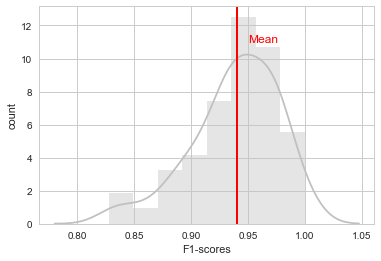

In [44]:
plt.figure()
sns.distplot(f1_scores, color='silver')
plt.xlabel('F1-scores')
plt.ylabel('count')
plt.plot([0.94, 0.94], [0, 15], 'r-', lw=2)
plt.text(s = 'Mean', y = 11, x = 0.95, color = 'red')
plt.savefig("../../data/plots/f1s_top_50_rf/svm_rbf_best.png") 
plt.show()

In [23]:
pre_X = top50_dataset.drop('labels', axis = 1)

f1_scores = []
for run in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

    svm_classifier = svm.LinearSVC(C=1, loss="hinge")

    print('Fitting model number: '  + str(run))
    svm_classifier.fit(X_train, y_train)

    print('Predicting...')
    #y_predicted = svm_classifier.predict(X_test)
    y_predicted = cross_val_predict(svm_classifier, X_test, y_test, cv=5)
    print('F1 Score:' + str(f1_score(y_test, y_predicted)))

    f1_scores.append(f1_score(y_test, y_predicted))

f1s = mean(f1_scores)
print('Final f1 score: ' + str(f1s))

Fitting model number: 0
Predicting...
F1 Score:0.893617021277
Fitting model number: 1
Predicting...
F1 Score:0.897959183673
Fitting model number: 2
Predicting...
F1 Score:1.0
Fitting model number: 3
Predicting...
F1 Score:0.980392156863
Fitting model number: 4
Predicting...
F1 Score:0.904761904762
Fitting model number: 5
Predicting...
F1 Score:1.0
Fitting model number: 6
Predicting...
F1 Score:0.974358974359
Fitting model number: 7
Predicting...
F1 Score:0.958333333333
Fitting model number: 8
Predicting...
F1 Score:1.0
Fitting model number: 9
Predicting...
F1 Score:0.829268292683
Fitting model number: 10
Predicting...
F1 Score:0.96
Fitting model number: 11
Predicting...
F1 Score:0.857142857143
Fitting model number: 12
Predicting...
F1 Score:0.857142857143
Fitting model number: 13
Predicting...
F1 Score:0.975609756098
Fitting model number: 14
Predicting...
F1 Score:0.756756756757
Fitting model number: 15
Predicting...
F1 Score:0.894736842105
Fitting model number: 16
Predicting...
F1 Sco

In [56]:
results_dataset = pd.DataFrame(columns=['Accuracy', 'F1-score', 'Classifier', 'Info'])
results_dataset.loc[0] = [0.83, 0.67, 'SVM', 'All Features']
results_dataset.loc[1] = [0.78, 0.62, 'SVM', 'Only Risk Genes']
results_dataset.loc[2] = [0.95, 0.94, 'SVM', 'Top Features']

results_dataset.loc[3] = [0.84, 0.8, 'Extra-Trees', 'All Features']
results_dataset.loc[4] = [0.64, 0.74, 'Extra-Trees', 'Only Risk Genes']
results_dataset.loc[5] = [0.89, 0.86, 'Extra-Trees', 'Top Features']

results_dataset.head() 

Accuracy  F1-score   Classifier             Info
0      0.83      0.67          SVM     All Features
1      0.78      0.62          SVM  Only Risk Genes
2      0.95      0.94          SVM     Top Features
3      0.84      0.80  Extra-Trees     All Features
4      0.64      0.74  Extra-Trees  Only Risk Genes

<Figure size 432x288 with 0 Axes>

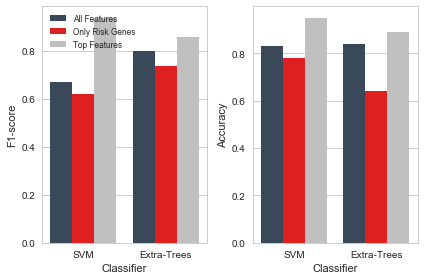

In [106]:
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, sharex='row')
flatui = ["#34495e", "#FF0000", "#C0C0C0"]

plt.tight_layout()

fontP = FontProperties()
fontP.set_size('small')

plt.subplot(1, 2, 1)
sns.barplot(x = 'Classifier', y = 'F1-score', hue = 'Info', data = results_dataset, palette=sns.color_palette(flatui)
)
plt.legend(prop = fontP)

plt.subplot(1, 2, 2)
sns.barplot(x = 'Classifier', y = 'Accuracy', hue = 'Info', data = results_dataset, palette=sns.color_palette(flatui)
)
plt.legend().remove()
plt.tight_layout()
plt.savefig('../../data/plots/classifiers_results/class_results.png', dpi = 300)